# Import Packages

In [1]:
import os, glob, random, time, sys, pickle, gc
from scipy.stats import wilcoxon
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa, librosa.display
import soundfile as sf
from scipy.optimize import minimize
import ast

from scipy import signal
from nnAudio.Spectrogram import CQT1992v2
from nnAudio import features


import colorednoise as cn
import cv2
import audioread
import logging
from contextlib import contextmanager
from joblib import Parallel, delayed
from pathlib import Path
from typing import Optional
import IPython

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, WeightedRandomSampler
import torch.utils.data as torchdata
# import torch.optim as optim
import torch_optimizer as optim
from torchvision import transforms, models, datasets
# from torchlibrosa.stft import Spectrogram, LogmelFilterBank
# from torchlibrosa.augmentation import SpecAugmentation
# from torchaudio.transforms import AmplitudeToDB, Spectrogram
from transformers import get_linear_schedule_with_warmup
import transformers
from torch.cuda.amp import autocast, GradScaler

from albumentations.core.transforms_interface import ImageOnlyTransform
# from torchlibrosa.stft import LogmelFilterBank, Spectrogram
from torchlibrosa.augmentation import SpecAugmentation
import pywt

from tqdm import tqdm
# from tqdm.notebook import tqdm
from functools import partial
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split, KFold
from sklearn.metrics import multilabel_confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix, mean_squared_error, precision_recall_fscore_support
from skimage.transform import resize

import albumentations as A
import albumentations.pytorch.transforms as T
from IPython.display import clear_output

from PIL import Image, ImageOps
import timm
from timm.models.efficientnet import tf_efficientnet_b0_ns, tf_efficientnet_b1_ns, tf_efficientnet_b2_ns, tf_efficientnet_b3_ns, tf_efficientnet_b4_ns
from timm.models.efficientnet import tf_efficientnet_b6_ns
from timm.models.mobilenetv3 import mobilenetv3_small_075, mobilenetv3_small_100, mobilenetv3_large_075, mobilenetv3_large_100
from timm.models.resnest import resnest50d, resnest101e, resnest200e

import warnings
# import warnings
# warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.__version__, np.__version__, pd.__version__

/home/edmans/anaconda3/envs/marine22/lib/python3.10/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


('1.12.1', '1.21.5', '1.4.4')

# Utils

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def mean_auc(y_true, y_pred):
    auc_mean = []
    for ncol in range(y_true.shape[1]):
        if np.sum(y_true[:,ncol])>0:
            auc_mean.append(roc_auc_score(y_true[:,ncol], y_pred[:, ncol]))
    return np.mean(auc_mean)

def one_hot_df(df):
    targets_one = np.zeros((df.shape[0],len(CFG.target_columns)))
#     for nrow, labels in enumerate(df.new_target):
    for nrow, ebird_code in enumerate(df.primary_label):
        targets_one[nrow, CFG.target_columns.index(ebird_code)] = 1.0  
    for nrow, labels in enumerate(df.secondary_other):
        for ebird_code in labels.split():
            targets_one[nrow,CFG.target_columns.index(ebird_code)] = 1.0
        
    return targets_one   

In [3]:
# Use from jupyter notebook notebook
from notebook import notebookapp
import urllib
import json
import ipykernel
from pathlib import Path

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

def create_output_dir(display = True, create=True, dirbase = '../results'):
    base_dir = Path(dirbase)
    if not os.path.exists(base_dir) and create:
        os.mkdir(base_dir)
    currentNotebook = notebook_path().split('/')
    currentNotebook = currentNotebook[-1]
    dir_models = currentNotebook[:-6]
    dir_models = dir_models.replace('.','_')
    output_dir = base_dir / Path(dir_models) #settings["globals"]["output_dir"])

    if not os.path.exists(output_dir) and create:
        os.mkdir(output_dir)
        if display:
            print("Directory " , output_dir ,  " Created ")
    elif display:
        print("Directory " , output_dir ,  " already exists")
    return output_dir

In [4]:
import math
from torch.optim.lr_scheduler import _LRScheduler
class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

# Config

In [5]:
# [i for i in timm.list_models(pretrained=True) if 'efficient' in i]

In [6]:
arquitectura = 'tf_efficientnet_b6_ns'
num_clases = 5
tramo_length = 2.0
  
device = ('cuda' if torch.cuda.is_available() else 'cpu')
SPECAUGMENT = False
NUM_FOLDS = 10
SEED = 1234
ENTRENA = False
USA_FP16 = False
device

'cuda'

# Create DataSet

In [7]:
if False:
    dataset1 = pd.read_csv("../input/labels_dataset1_v2.csv")
    print(dataset1.shape)
    df = dataset1.query('label!="volcano"').drop_duplicates()
    print(df.shape)
    df.label.value_counts()

    len_audio = []
    sr_audio = []
    seconds_audio = []
    for name_file in tqdm(df.path.unique()):
        y, sr = sf.read(f'../input/datathon2022/dataset1/{name_file}.wav')
        len_audio.append(len(y))
        sr_audio.append(sr)
        seconds_audio.append(len(y)/sr)
    df['len_audio'] = df['path'].map(dict(zip(df.path.unique(), len_audio)))
    df['sr_audio'] = df['path'].map(dict(zip(df.path.unique(), sr_audio)))
    df['seconds_audio'] = df['path'].map(dict(zip(df.path.unique(), seconds_audio)))
    df['dir'] = ['../input/datathon2022/dataset1/'+i+'.wav' for i in df['path']]
    df['clase'] = df['label'].values
    df['pos_ini'] = df['start'] * df['sr_audio']
    df['pos_fin'] = df['end'] * df['sr_audio']

    clases = dict(df['clase'].value_counts())
    clases_num = dict(zip(list(clases.keys()), np.arange(len(clases))))
    df['clase_num'] = df['clase'].map(clases_num)
    labels = pd.get_dummies(df['clase'])
    
    db_troceada = []
    labels_troceada = []
    step_audio = int(tramo_length * 50000)
    for namefile in tqdm(df['path'].unique()):
        df_file = df.query(f'path=="{namefile}"').reset_index()
        df_file['start_pos'] = df_file[['start']].values * 50000
        df_file['end_pos'] = df_file[['end']].values * 50000
        df_file['start_pos']  = df_file['start_pos'].astype(int)
        df_file['end_pos']  = df_file['end_pos'].astype(int)
        for pos_ini in np.arange(0,14700000,step_audio):
            pos_fin = pos_ini + step_audio
            if pos_fin > 14700000:
                pos_fin = 14700000
            pos_dentro = (pos_ini>df_file['start_pos'].values) & (pos_ini<df_file['end_pos'].values)
            labels_list = []
            if np.sum(pos_dentro>0):
                labels_list = list(np.unique(df_file.loc[pos_dentro, 'label'].values))
#                 print(namefile, pos_ini, pos_fin, labels)
            db_troceada.append(dict(namefile=namefile,
                                    dir=f'../input/datathon2022/dataset1/{namefile}.wav',
                                    start=float(pos_ini/50000),
                                    end=float(pos_fin/50000),
                                    pos_ini=pos_ini,
                                    pos_fin=pos_fin,
                                    labels=labels_list))
            labels_row = np.zeros(len(clases_num))
            for label in labels_list:
                labels_row[clases_num[label]] = 1.0
            labels_troceada.append(labels_row)
            
    db_troceada = pd.DataFrame(db_troceada)
    labels_troceada = pd.DataFrame(np.stack(labels_troceada))
    labels_troceada.columns = list(clases_num.keys())

    with open('database_datathon2022.pickle', 'wb') as f:
        pickle.dump(df, f)
        pickle.dump(clases, f)
        pickle.dump(clases_num, f)
        pickle.dump(labels, f)
        pickle.dump(db_troceada, f)
        pickle.dump(labels_troceada, f)
else:
    with open('database_datathon2022.pickle', 'rb') as f:
        df = pickle.load(f)
        clases = pickle.load(f)
        clases_num = pickle.load(f)
        labels = pickle.load(f)
        db_troceada = pickle.load(f)
        labels_troceada = pickle.load(f)
df.head()

,path,start,duration,end,label,len_audio,sr_audio,seconds_audio,dir,clase,pos_ini,pos_fin,clase_num
0,012213d40662f86e8f775379bbf94dec,61.186,2.500,63.686,whistle,14700000,50000,294.0,../input/datathon2022/dataset1/012213d40662f86...,whistle,3059300.0,3184300.0,0
1,0159af9f3ca04ada46f0c353ac210bb8,76.260,17.000,93.260,cetaceans_allfreq,14700000,50000,294.0,../input/datathon2022/dataset1/0159af9f3ca04ad...,cetaceans_allfreq,3813000.0,4663000.0,2
2,0159af9f3ca04ada46f0c353ac210bb8,161.482,1.000,162.482,click,14700000,50000,294.0,../input/datathon2022/dataset1/0159af9f3ca04ad...,click,8074100.0,8124100.0,1
3,0271a0818427d7fae7afde67bf49ba30,91.563,1.000,92.563,click,14700000,50000,294.0,../input/datathon2022/dataset1/0271a0818427d7f...,click,4578150.0,4628150.0,1
4,0271a0818427d7fae7afde67bf49ba30,125.627,1.316,126.943,click,14700000,50000,294.0,../input/datathon2022/dataset1/0271a0818427d7f...,click,6281350.0,6347150.0,1


In [8]:
eventos = df.copy()

## Selecciona DB

In [9]:
df_train_orig = db_troceada.reset_index(drop=True)
labels_train_orig = labels_troceada
df_train_orig.shape, labels_train_orig.shape

((66444, 7), (66444, 4))

In [10]:
hay_evento = (labels_train_orig.sum(axis=1)>0)
hay_evento.value_counts()

False    58611
True      7833
dtype: int64

In [11]:
df_train_orig.loc[hay_evento].sample(3)

,namefile,dir,start,end,pos_ini,pos_fin,labels
15012,3ed63258dd61d4ea0ed4c86e8f8a55b6,../input/datathon2022/dataset1/3ed63258dd61d4e...,36.0,38.0,1800000,1900000,[whistle]
578,035195366b6849c1b339cff8e6de574a,../input/datathon2022/dataset1/035195366b6849c...,274.0,276.0,13700000,13800000,[click]
36444,88eecf9fba039e47611d7284352fe0f6,../input/datathon2022/dataset1/88eecf9fba039e4...,270.0,272.0,13500000,13600000,[whistle]


In [12]:
df_train = df_train_orig.copy()
labels_train = labels_train_orig.copy()

In [13]:
(labels_train.sum(axis=1)>0).value_counts()

False    58611
True      7833
dtype: int64

# Augmentations

## Noise Funs

In [14]:
class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray, sr):
        for trns in self.transforms:
            y = trns(y, sr)
        return y


class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray, sr):
        if self.always_apply:
            return self.apply(y, sr=sr)
        else:
            if np.random.rand() < self.p:
                return self.apply(y, sr=sr)
            else:
                return y

    def apply(self, y: np.ndarray, **params):
        raise NotImplementedError


class OneOf(Compose):
    # https://github.com/albumentations-team/albumentations/blob/master/albumentations/core/composition.py
    def __init__(self, transforms, p=0.5):
        super().__init__(transforms)
        self.p = p
        transforms_ps = [t.p for t in transforms]
        s = sum(transforms_ps)
        self.transforms_ps = [t / s for t in transforms_ps]

    def __call__(self, y: np.ndarray, sr):
        data = y
        if self.transforms_ps and (random.random() < self.p):
            random_state = np.random.RandomState(random.randint(0, 2 ** 32 - 1))
            t = random_state.choice(self.transforms, p=self.transforms_ps)
            data = t(y, sr)
        return data


class Normalize(AudioTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply, p)

    def apply(self, y: np.ndarray, **params):
        max_vol = np.abs(y).max()
        y_vol = y * 1 / max_vol
        return np.asfortranarray(y_vol)


class NewNormalize(AudioTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply, p)

    def apply(self, y: np.ndarray, **params):
        y_mm = y - y.mean()
        return y_mm / y_mm.abs().max()


class NoiseInjection(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_noise_level=0.5):
        super().__init__(always_apply, p)

        self.noise_level = (0.0, max_noise_level)

    def apply(self, y: np.ndarray, **params):
        noise_level = np.random.uniform(*self.noise_level)
        noise = np.random.randn(len(y))
        augmented = (y + noise * noise_level).astype(y.dtype)
        return augmented


class GaussianNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        white_noise = np.random.randn(len(y))
        a_white = np.sqrt(white_noise ** 2).max()
        augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
        return augmented


class PinkNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
        a_pink = np.sqrt(pink_noise ** 2).max()
        augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
        return augmented


class PitchShift(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_range=5):
        super().__init__(always_apply, p)
        self.max_range = max_range

    def apply(self, y: np.ndarray, sr, **params):
        n_steps = np.random.randint(-self.max_range, self.max_range)
        augmented = librosa.effects.pitch_shift(y, sr, n_steps)
        return augmented


class TimeStretch(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_rate=1):
        super().__init__(always_apply, p)
        self.max_rate = max_rate

    def apply(self, y: np.ndarray, **params):
        rate = np.random.uniform(0, self.max_rate)
        augmented = librosa.effects.time_stretch(y, rate)
        return augmented


def _db2float(db: float, amplitude=True):
    if amplitude:
        return 10 ** (db / 20)
    else:
        return 10 ** (db / 10)


def volume_down(y: np.ndarray, db: float):
    """
    Low level API for decreasing the volume
    Parameters
    ----------
    y: numpy.ndarray
        stereo / monaural input audio
    db: float
        how much decibel to decrease
    Returns
    -------
    applied: numpy.ndarray
        audio with decreased volume
    """
    applied = y * _db2float(-db)
    return applied


def volume_up(y: np.ndarray, db: float):
    """
    Low level API for increasing the volume
    Parameters
    ----------
    y: numpy.ndarray
        stereo / monaural input audio
    db: float
        how much decibel to increase
    Returns
    -------
    applied: numpy.ndarray
        audio with increased volume
    """
    applied = y * _db2float(db)
    return applied


class RandomVolume(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, limit=10):
        super().__init__(always_apply, p)
        self.limit = limit

    def apply(self, y: np.ndarray, **params):
        db = np.random.uniform(-self.limit, self.limit)
        if db >= 0:
            return volume_up(y, db)
        else:
            return volume_down(y, db)


class CosineVolume(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, limit=10):
        super().__init__(always_apply, p)
        self.limit = limit

    def apply(self, y: np.ndarray, **params):
        db = np.random.uniform(-self.limit, self.limit)
        cosine = np.cos(np.arange(len(y)) / len(y) * np.pi * 2)
        dbs = _db2float(cosine * db)
        return y * dbs

## AudioAumentations

In [15]:
import audiomentations as AA
reduce = 0.90
train_audio_transform = AA.Compose([
#     AA.AddGaussianNoise(p=0.1), #0.5
#     AA.AddGaussianSNR(max_SNR=1.25, p=0.50),  #0.5
#     AA.AddBackgroundNoise("../input/train_audio/", p=1)
#     AA.AddImpulseResponse(p=0.1),
    #AA.AddShortNoises("../input/train_audio/", p=1)
#     AA.FrequencyMask(min_frequency_band=0.0,  max_frequency_band=0.2, p=0.50),
    #AA.TimeMask(min_band_part=0.0, max_band_part=0.2, p=0.1),
#     AA.PitchShift(min_semitones=-4, max_semitones=4),
#     AA.Shift(p=0.01),
    #AA.Normalize(p=0.1),
    #AA.PolarityInversion(p=0.05),
    AA.Shift(min_fraction=-0.25*reduce, max_fraction=0.25*reduce, p=0.50),
    AA.AddGaussianSNR(max_snr_in_db=1.25*reduce, p=0.50),  #0.5
    AA.ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=int(32*reduce), p=0.50),
    AA.Gain(min_gain_in_db=-int(12*reduce), max_gain_in_db=int(12*reduce), p=0.50),
])

## SpecAugment

In [16]:
# From https://github.com/DemisEom/SpecAugment/tree/master/SpecAugment
def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]

    y = num_rows // 2
    horizontal_line_at_ctr = spec[0][y]
    # assert len(horizontal_line_at_ctr) == spec_len

    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len-W)]
    # assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts = torch.tensor([[[y, point_to_warp]]])
    dest_pts = torch.tensor([[[y, point_to_warp + dist_to_warp]]])
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)


def freq_mask(spec, F=15, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]

    for i in range(0, num_masks):
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f)
        if (replace_with_zero):
            cloned[0][f_zero:mask_end] = 0
        else:
            cloned[0][f_zero:mask_end] = cloned.mean()

    return cloned


def time_mask(spec, T=15, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]

    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero):
            cloned[0][:, t_zero:mask_end] = 0
        else:
            cloned[0][:, t_zero:mask_end] = cloned.mean()
    return cloned


def sparse_image_warp(img_tensor,
                      source_control_point_locations,
                      dest_control_point_locations,
                      interpolation_order=2,
                      regularization_weight=0.0,
                      num_boundaries_points=0):
    control_point_flows = (dest_control_point_locations - source_control_point_locations)

    batch_size, image_height, image_width = img_tensor.shape
    grid_locations = get_grid_locations(image_height, image_width)
    flattened_grid_locations = torch.tensor(flatten_grid_locations(grid_locations, image_height, image_width))

    flattened_flows = interpolate_spline(
        dest_control_point_locations,
        control_point_flows,
        flattened_grid_locations,
        interpolation_order,
        regularization_weight)

    dense_flows = create_dense_flows(flattened_flows, batch_size, image_height, image_width)

    warped_image = dense_image_warp(img_tensor, dense_flows)

    return warped_image, dense_flows


def get_grid_locations(image_height, image_width):
    """Wrapper for np.meshgrid."""

    y_range = np.linspace(0, image_height - 1, image_height)
    x_range = np.linspace(0, image_width - 1, image_width)
    y_grid, x_grid = np.meshgrid(y_range, x_range, indexing='ij')
    return np.stack((y_grid, x_grid), -1)


def flatten_grid_locations(grid_locations, image_height, image_width):
    return np.reshape(grid_locations, [image_height * image_width, 2])


def create_dense_flows(flattened_flows, batch_size, image_height, image_width):
    # possibly .view
    return torch.reshape(flattened_flows, [batch_size, image_height, image_width, 2])


def interpolate_spline(train_points, train_values, query_points, order, regularization_weight=0.0, ):
    # First, fit the spline to the observed data.
    w, v = solve_interpolation(train_points, train_values, order, regularization_weight)
    # Then, evaluate the spline at the query locations.
    query_values = apply_interpolation(query_points, train_points, w, v, order)

    return query_values


def solve_interpolation(train_points, train_values, order, regularization_weight):
    b, n, d = train_points.shape
    k = train_values.shape[-1]

    # First, rename variables so that the notation (c, f, w, v, A, B, etc.)
    # follows https://en.wikipedia.org/wiki/Polyharmonic_spline.
    # To account for python style guidelines we use
    # matrix_a for A and matrix_b for B.

    c = train_points
    f = train_values.float()

    matrix_a = phi(cross_squared_distance_matrix(c, c), order).unsqueeze(0)  # [b, n, n]
    #     if regularization_weight > 0:
    #         batch_identity_matrix = array_ops.expand_dims(
    #           linalg_ops.eye(n, dtype=c.dtype), 0)
    #         matrix_a += regularization_weight * batch_identity_matrix

    # Append ones to the feature values for the bias term in the linear model.
    ones = torch.ones(1, dtype=train_points.dtype).view([-1, 1, 1])
    matrix_b = torch.cat((c, ones), 2).float()  # [b, n, d + 1]

    # [b, n + d + 1, n]
    left_block = torch.cat((matrix_a, torch.transpose(matrix_b, 2, 1)), 1)

    num_b_cols = matrix_b.shape[2]  # d + 1

    # In Tensorflow, zeros are used here. Pytorch gesv fails with zeros for some reason we don't understand.
    # So instead we use very tiny randn values (variance of one, zero mean) on one side of our multiplication.
    lhs_zeros = torch.randn((b, num_b_cols, num_b_cols)) / 1e10
    right_block = torch.cat((matrix_b, lhs_zeros),
                            1)  # [b, n + d + 1, d + 1]
    lhs = torch.cat((left_block, right_block),
                    2)  # [b, n + d + 1, n + d + 1]

    rhs_zeros = torch.zeros((b, d + 1, k), dtype=train_points.dtype).float()
    rhs = torch.cat((f, rhs_zeros), 1)  # [b, n + d + 1, k]

    # Then, solve the linear system and unpack the results.
    X = torch.linalg.solve(lhs, rhs)
    w = X[:, :n, :]
    v = X[:, n:, :]

    return w, v

def solve_interpolation(train_points, train_values, order, regularization_weight):
    b, n, d = train_points.shape
    k = train_values.shape[-1]

    # First, rename variables so that the notation (c, f, w, v, A, B, etc.)
    # follows https://en.wikipedia.org/wiki/Polyharmonic_spline.
    # To account for python style guidelines we use
    # matrix_a for A and matrix_b for B.

    c = train_points
    f = train_values.float()

    matrix_a = phi(cross_squared_distance_matrix(c, c), order).unsqueeze(0)  # [b, n, n]
    #     if regularization_weight > 0:
    #         batch_identity_matrix = array_ops.expand_dims(
    #           linalg_ops.eye(n, dtype=c.dtype), 0)
    #         matrix_a += regularization_weight * batch_identity_matrix

    # Append ones to the feature values for the bias term in the linear model.
    ones = torch.ones(1, dtype=train_points.dtype).view([-1, 1, 1])
    matrix_b = torch.cat((c, ones), 2).float()  # [b, n, d + 1]

    # [b, n + d + 1, n]
    left_block = torch.cat((matrix_a, torch.transpose(matrix_b, 2, 1)), 1)

    num_b_cols = matrix_b.shape[2]  # d + 1

    # In Tensorflow, zeros are used here. Pytorch gesv fails with zeros for some reason we don't understand.
    # So instead we use very tiny randn values (variance of one, zero mean) on one side of our multiplication.
    lhs_zeros = torch.randn((b, num_b_cols, num_b_cols)) / 1e10
    right_block = torch.cat((matrix_b, lhs_zeros),
                            1)  # [b, n + d + 1, d + 1]
    lhs = torch.cat((left_block, right_block),
                    2)  # [b, n + d + 1, n + d + 1]

    rhs_zeros = torch.zeros((b, d + 1, k), dtype=train_points.dtype).float()
    rhs = torch.cat((f, rhs_zeros), 1)  # [b, n + d + 1, k]

    # Then, solve the linear system and unpack the results.
    X = torch.linalg.solve(lhs, rhs)
    w = X[:, :n, :]
    v = X[:, n:, :]

    return w, v


def cross_squared_distance_matrix(x, y):
    """Pairwise squared distance between two (batch) matrices' rows (2nd dim).
        Computes the pairwise distances between rows of x and rows of y
        Args:
        x: [batch_size, n, d] float `Tensor`
        y: [batch_size, m, d] float `Tensor`
        Returns:
        squared_dists: [batch_size, n, m] float `Tensor`, where
        squared_dists[b,i,j] = ||x[b,i,:] - y[b,j,:]||^2
    """
    x_norm_squared = torch.sum(torch.mul(x, x))
    y_norm_squared = torch.sum(torch.mul(y, y))

    x_y_transpose = torch.matmul(x.squeeze(0), y.squeeze(0).transpose(0, 1))

    # squared_dists[b,i,j] = ||x_bi - y_bj||^2 = x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = x_norm_squared - 2 * x_y_transpose + y_norm_squared

    return squared_dists.float()


def phi(r, order):
    """Coordinate-wise nonlinearity used to define the order of the interpolation.
    See https://en.wikipedia.org/wiki/Polyharmonic_spline for the definition.
    Args:
    r: input op
    order: interpolation order
    Returns:
    phi_k evaluated coordinate-wise on r, for k = r
    """
    EPSILON = torch.tensor(1e-10)
    # using EPSILON prevents log(0), sqrt0), etc.
    # sqrt(0) is well-defined, but its gradient is not
    if order == 1:
        r = torch.max(r, EPSILON)
        r = torch.sqrt(r)
        return r
    elif order == 2:
        return 0.5 * r * torch.log(torch.max(r, EPSILON))
    elif order == 4:
        return 0.5 * torch.square(r) * torch.log(torch.max(r, EPSILON))
    elif order % 2 == 0:
        r = torch.max(r, EPSILON)
        return 0.5 * torch.pow(r, 0.5 * order) * torch.log(r)
    else:
        r = torch.max(r, EPSILON)
        return torch.pow(r, 0.5 * order)


def apply_interpolation(query_points, train_points, w, v, order):
    """Apply polyharmonic interpolation model to data.
    Given coefficients w and v for the interpolation model, we evaluate
    interpolated function values at query_points.
    Args:
    query_points: `[b, m, d]` x values to evaluate the interpolation at
    train_points: `[b, n, d]` x values that act as the interpolation centers
                    ( the c variables in the wikipedia article)
    w: `[b, n, k]` weights on each interpolation center
    v: `[b, d, k]` weights on each input dimension
    order: order of the interpolation
    Returns:
    Polyharmonic interpolation evaluated at points defined in query_points.
    """
    query_points = query_points.unsqueeze(0)
    # First, compute the contribution from the rbf term.
    pairwise_dists = cross_squared_distance_matrix(query_points.float(), train_points.float())
    phi_pairwise_dists = phi(pairwise_dists, order)

    rbf_term = torch.matmul(phi_pairwise_dists, w)

    # Then, compute the contribution from the linear term.
    # Pad query_points with ones, for the bias term in the linear model.
    ones = torch.ones_like(query_points[..., :1])
    query_points_pad = torch.cat((
        query_points,
        ones
    ), 2).float()
    linear_term = torch.matmul(query_points_pad, v)

    return rbf_term + linear_term


def dense_image_warp(image, flow):
    """Image warping using per-pixel flow vectors.
    Apply a non-linear warp to the image, where the warp is specified by a dense
    flow field of offset vectors that define the correspondences of pixel values
    in the output image back to locations in the  source image. Specifically, the
    pixel value at output[b, j, i, c] is
    images[b, j - flow[b, j, i, 0], i - flow[b, j, i, 1], c].
    The locations specified by this formula do not necessarily map to an int
    index. Therefore, the pixel value is obtained by bilinear
    interpolation of the 4 nearest pixels around
    (b, j - flow[b, j, i, 0], i - flow[b, j, i, 1]). For locations outside
    of the image, we use the nearest pixel values at the image boundary.
    Args:
    image: 4-D float `Tensor` with shape `[batch, height, width, channels]`.
    flow: A 4-D float `Tensor` with shape `[batch, height, width, 2]`.
    name: A name for the operation (optional).
    Note that image and flow can be of type tf.half, tf.float32, or tf.float64,
    and do not necessarily have to be the same type.
    Returns:
    A 4-D float `Tensor` with shape`[batch, height, width, channels]`
    and same type as input image.
    Raises:
    ValueError: if height < 2 or width < 2 or the inputs have the wrong number
    of dimensions.
    """
    image = image.unsqueeze(3)  # add a single channel dimension to image tensor
    batch_size, height, width, channels = image.shape

    # The flow is defined on the image grid. Turn the flow into a list of query
    # points in the grid space.
    grid_x, grid_y = torch.meshgrid(
        torch.arange(width), torch.arange(height))

    stacked_grid = torch.stack((grid_y, grid_x), dim=2).float()

    batched_grid = stacked_grid.unsqueeze(-1).permute(3, 1, 0, 2)

    query_points_on_grid = batched_grid - flow
    query_points_flattened = torch.reshape(query_points_on_grid,
                                           [batch_size, height * width, 2])
    # Compute values at the query points, then reshape the result back to the
    # image grid.
    interpolated = interpolate_bilinear(image, query_points_flattened)
    interpolated = torch.reshape(interpolated,
                                 [batch_size, height, width, channels])
    return interpolated


def interpolate_bilinear(grid,
                         query_points,
                         name='interpolate_bilinear',
                         indexing='ij'):
    """Similar to Matlab's interp2 function.
    Finds values for query points on a grid using bilinear interpolation.
    Args:
    grid: a 4-D float `Tensor` of shape `[batch, height, width, channels]`.
    query_points: a 3-D float `Tensor` of N points with shape `[batch, N, 2]`.
    name: a name for the operation (optional).
    indexing: whether the query points are specified as row and column (ij),
      or Cartesian coordinates (xy).
    Returns:
    values: a 3-D `Tensor` with shape `[batch, N, channels]`
    Raises:
    ValueError: if the indexing mode is invalid, or if the shape of the inputs
      invalid.
    """
    if indexing != 'ij' and indexing != 'xy':
        raise ValueError('Indexing mode must be \'ij\' or \'xy\'')

    shape = grid.shape
    if len(shape) != 4:
        msg = 'Grid must be 4 dimensional. Received size: '
        raise ValueError(msg + str(grid.shape))

    batch_size, height, width, channels = grid.shape

    shape = [batch_size, height, width, channels]
    query_type = query_points.dtype
    grid_type = grid.dtype

    num_queries = query_points.shape[1]

    alphas = []
    floors = []
    ceils = []
    index_order = [0, 1] if indexing == 'ij' else [1, 0]
    unstacked_query_points = query_points.unbind(2)

    for dim in index_order:
        queries = unstacked_query_points[dim]

        size_in_indexing_dimension = shape[dim + 1]

        # max_floor is size_in_indexing_dimension - 2 so that max_floor + 1
        # is still a valid index into the grid.
        max_floor = torch.tensor(size_in_indexing_dimension - 2, dtype=query_type)
        min_floor = torch.tensor(0.0, dtype=query_type)
        maxx = torch.max(min_floor, torch.floor(queries))
        floor = torch.min(maxx, max_floor)
        int_floor = floor.long()
        floors.append(int_floor)
        ceil = int_floor + 1
        ceils.append(ceil)

        # alpha has the same type as the grid, as we will directly use alpha
        # when taking linear combinations of pixel values from the image.
        alpha = (queries-floor).clone().detach().type(grid_type)
        min_alpha = torch.tensor(0.0, dtype=grid_type)
        max_alpha = torch.tensor(1.0, dtype=grid_type)
        alpha = torch.min(torch.max(min_alpha, alpha), max_alpha)

        # Expand alpha to [b, n, 1] so we can use broadcasting
        # (since the alpha values don't depend on the channel).
        alpha = torch.unsqueeze(alpha, 2)
        alphas.append(alpha)

    flattened_grid = torch.reshape(
        grid, [batch_size * height * width, channels])
    batch_offsets = torch.reshape(
        torch.arange(batch_size) * height * width, [batch_size, 1])

    # This wraps array_ops.gather. We reshape the image data such that the
    # batch, y, and x coordinates are pulled into the first dimension.
    # Then we gather. Finally, we reshape the output back. It's possible this
    # code would be made simpler by using array_ops.gather_nd.
    def gather(y_coords, x_coords, name):
        linear_coordinates = batch_offsets + y_coords * width + x_coords
        gathered_values = torch.gather(flattened_grid.t(), 1, linear_coordinates)
        return torch.reshape(gathered_values,
                             [batch_size, num_queries, channels])

    # grab the pixel values in the 4 corners around each query point
    top_left = gather(floors[0], floors[1], 'top_left')
    top_right = gather(floors[0], ceils[1], 'top_right')
    bottom_left = gather(ceils[0], floors[1], 'bottom_left')
    bottom_right = gather(ceils[0], ceils[1], 'bottom_right')

    interp_top = alphas[1] * (top_right - top_left) + top_left
    interp_bottom = alphas[1] * (bottom_right - bottom_left) + bottom_left
    interp = alphas[0] * (interp_bottom - interp_top) + interp_top

    return interp

def spec_augment(mel_spectrogram, time_warping_para=80, frequency_masking_para=27,
                 time_masking_para=100, frequency_mask_num=1, time_mask_num=1):
    """Spec augmentation Calculation Function.
    'SpecAugment' have 3 steps for audio data augmentation.
    first step is time warping using Tensorflow's image_sparse_warp function.
    Second step is frequency masking, last step is time masking.
    # Arguments:
      mel_spectrogram(numpy array): audio file path of you want to warping and masking.
      time_warping_para(float): Augmentation parameter, "time warp parameter W".
        If none, default = 80 for LibriSpeech.
      frequency_masking_para(float): Augmentation parameter, "frequency mask parameter F"
        If none, default = 100 for LibriSpeech.
      time_masking_para(float): Augmentation parameter, "time mask parameter T"
        If none, default = 27 for LibriSpeech.
      frequency_mask_num(float): number of frequency masking lines, "m_F".
        If none, default = 1 for LibriSpeech.
      time_mask_num(float): number of time masking lines, "m_T".
        If none, default = 1 for LibriSpeech.
    # Returns
      mel_spectrogram(numpy array): warped and masked mel spectrogram.
    """
    v = mel_spectrogram.shape[1]
    tau = mel_spectrogram.shape[2]

    # Step 1 : Time warping
    warped_mel_spectrogram = time_warp(mel_spectrogram, W=time_warping_para)

    # Step 2 : Frequency masking
    for i in range(frequency_mask_num):
        f = np.random.uniform(low=0.0, high=frequency_masking_para)
        f = int(f)
        f0 = random.randint(0, v-f)
        warped_mel_spectrogram[:, f0:f0+f, :] = 0

    # Step 3 : Time masking
    for i in range(time_mask_num):
        t = np.random.uniform(low=0.0, high=time_masking_para)
        t = int(t)
        t0 = random.randint(0, tau-t)
        warped_mel_spectrogram[:, :, t0:t0+t] = 0

    return warped_mel_spectrogram

# Visualize Spectograms

Text(0.5, 1.0, 'Nombre=012213d40662f86e8f775379bbf94dec sr=50000 len_y=0.25 seg')

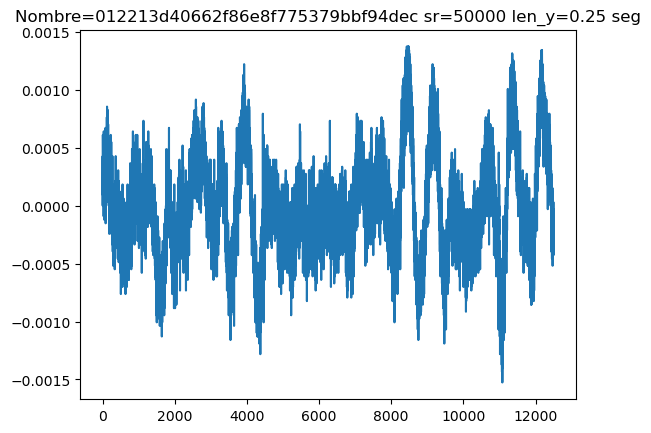

In [17]:
record = eventos.iloc[0]
start = record['start']
end = record['end']
duration = record['duration']
if duration>3.0:
    start = np.random.uniform(start, end-3.0)
    end = start+3.0
    
y_crop, sr = sf.read(record['dir'], start=int(start*5000), stop=int(end*5000))
# y = y * 15 #(y-np.mean(y))/np.std(y)
plt.plot(y_crop)
plt.title(f'Nombre={record["path"].split("/")[-1]} sr={sr} len_y={len(y_crop)/sr} seg')
# print(record)

In [18]:
def fft_img(y, size_img=528):
    spec_layer = features.STFT(sr=50000, n_fft=1024, freq_bins=None, hop_length=256,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                              fmin=0,fmax=25000, output_format='Magnitude', verbose=False).to(device) # Initializing the model
    img = spec_layer(torch.tensor(y).float().to(device)).squeeze(0)
    img = torch.log(img+1e-10)
#     print(img.shape)
    img = img.transpose(0,1)
    f_min = 0
    f_max = 25000
    t_min = 0
    t_max = len(y) / 50000.0
    sample_rate = 50000
    duration = 3.0
    img = img.float().unsqueeze(0).unsqueeze(0)
    time_sampler = torch.linspace(2*t_min/duration-1,2*t_max/duration-1,size_img)
    freq_sampler = torch.linspace(4*f_min/sample_rate-1,4*f_max/sample_rate-1,size_img)
    mg=torch.stack(torch.meshgrid(freq_sampler,time_sampler,),dim=-1).unsqueeze(0).to(device)
    img = F.grid_sample(img,mg,align_corners=True).squeeze(0)
    return img

# print("FFT")
# record = eventos.iloc[0]
# start = record['start']
# end = record['end']
# duration = record['duration']
# if duration>3.0:
#     start = np.random.uniform(start, end-3.0)
#     end = start+3.0
# duration = end-start
# print(duration)
# y_crop, sample_rate = sf.read(record['dir'], start=int(start*50000), stop=int(end*50000))

# img = fft_img(y_crop)
# print(img.min(), img.max())
# plt.figure(figsize=(10,10))
# plt.imshow(img.squeeze(0).detach().cpu().numpy())
# # plt.imshow(img.transpose(1,2).squeeze(0).numpy())
# plt.title(f'FFT -> {img.shape}')
# plt.show()

In [19]:
def cqt_img(y, size_img=528):
    spec_layer = features.CQT1992v2(sr=50000, hop_length=512, fmin=10, fmax=None,n_bins=40,
    bins_per_octave=8,  filter_scale=1, norm=1, window='hann', center=True, pad_mode='reflect', trainable=False,
    output_format='Magnitude', verbose=False).to(device) # Initializing the model
    img = spec_layer(torch.tensor(y).float().to(device)).squeeze(0)
    img = torch.log(img+1e-10)
#     print(img.shape)
    img = img.transpose(0,1)
    time_bins, freq_bins = img.shape
    f_min = 0
    f_max = 25000
    t_min = 0
    t_max = len(y) / 50000.0
    sample_rate = 50000.0
    duration = 3.0
    img = img.float().unsqueeze(0).unsqueeze(0)
    time_sampler = torch.linspace(2*t_min/duration-1,2*t_max/duration-1,size_img)
    freq_sampler = torch.linspace(4*f_min/sample_rate-1,4*f_max/sample_rate-1,size_img)
    mg=torch.stack(torch.meshgrid(freq_sampler,time_sampler,),dim=-1).unsqueeze(0).to(device)
    img = F.grid_sample(img,mg,align_corners=True).squeeze(0)
    return img

# print("CQT")
# record = eventos.iloc[0]
# start = record['start']
# end = record['end']
# duration = record['duration']
# if duration>3.0:
#     start = np.random.uniform(start, end-3.0)
#     end = start+3.0
# end = start + 1.0
# duration = end-start
# print(duration)
# y_crop, sample_rate = sf.read(record['dir'], start=int(start*50000), stop=int(end*50000))

# img = cqt_img(y_crop)
# print(img.min(), img.max())
# plt.figure(figsize=(10,10))
# plt.imshow(img.squeeze(0).detach().cpu().numpy())
# # plt.imshow(img.transpose(1,2).squeeze(0).numpy())
# plt.title(f'CQT -> {img.shape}')
# plt.show()


# DataLoaders

In [20]:
class SedDataset:
    def __init__(self, df, eventos, tramo_length_min = 2.0, tramo_length_max = 3.0, audio_transform=None, modo="train"):
        self.audio_transform = audio_transform
        self.modo = modo
        self.df = df
        self.eventos = eventos
        self.tramo_length_min = tramo_length_min
        self.tramo_length_max = tramo_length_max

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        name_file = record['path']
        namedir = record['dir']
        start = record['start']
        end = record['end']
        duration = end-start
        label = record['label']
        if self.modo == "train":
            if np.random.uniform() < 0.50:
                # Select fragment
                if duration>self.tramo_length_max:
                    start = np.random.uniform(start, end - self.tramo_length_max)
                    end = start+np.random.uniform(self.tramo_length_min, self.tramo_length_max)
                    duration = end-start
            else:
                start = np.random.uniform(0, 294.0 - self.tramo_length_max)
                end = start+np.random.uniform(self.tramo_length_min, self.tramo_length_max)
                duration = end-start
                label = None
        else:
            start = record['start']
            end = record['end']
            
        # Cogemos mínimo 1 segundo
        if (end-start) < 1.0:
            start -= np.random.uniform()
            end = start + 1.0
            if start < 0.0:
                start = 0.0
                end = 1.0
            elif end > 294.0:
                end = 294.0
                start = end - 1.0
        
        y, sr = sf.read(namedir, start=int(start*50000), stop=int(end*50000))
        

        # Agumentation in audio
        if self.audio_transform:
            y = self.audio_transform(samples=y, sample_rate=sr)

        img_fft = fft_img(y)
        img_cqt = cqt_img(y)
        # Specaugment
#         img_fft = img_fft.unsqueeze(0)
#         img_cqt = img_cqt.unsqueeze(0)
        
        if self.modo=='train' and SPECAUGMENT:
            img_fft = spec_augment(img_fft, time_warping_para=1, 
                               time_masking_para=36,  time_mask_num=2,
                               frequency_masking_para=36, frequency_mask_num=2)
#             img_cqt = spec_augment(img_cqt, time_warping_para=1, 
#                                time_masking_para=36,  time_mask_num=2,
#                                frequency_masking_para=36, frequency_mask_num=2)

        labels = 0
        if self.modo=='train' or self.modo=='valid':
            labels = np.zeros(5)
            if label != None:
                labels[clases_num[label]] = 1.0
                dentro_caja = self.eventos.query('path == @name_file').reset_index(drop=True)
#                 print(start, end, label)
#                 print(dentro_caja)
            else:
                dentro_caja = self.eventos.query('path == @name_file').reset_index(drop=True)
#                 print(start, end, label)
#                 print(dentro_caja)
                if len(dentro_caja)>0:
                    start_caja = dentro_caja['start']
                    end_caja = dentro_caja['end']
                    es_dentro1 = (start >= start_caja) & (start <= (end_caja-0.50))
                    es_dentro2 = (end > (start_caja+0.50)) & (end < end_caja)
                    es_dentro3 = (start_caja==start) & (end_caja==end)
                    es_dentro = es_dentro1 | es_dentro2 | es_dentro3
                    dentro_caja = dentro_caja[es_dentro].reset_index(drop=True)
                    if len(dentro_caja)>0:
                        for nrow, row in dentro_caja.sample(frac=1).iterrows():
                            label = row['label']
                            labels[clases_num[label]] = 1.0
                            break
    
            
            if np.sum(labels)==0:
                labels[4] = 1.0
            # indices = np.linspace(pos_ini, pos_fin, 513)
            # labels = np.zeros((513, 4))
            # for nrow, row in dentro_caja.iterrows():
            #     pos_ini_label = row['pos_ini']
            #     pos_fin_label = row['pos_fin']
            #     label = row['label']
            #     labels[(indices>=pos_ini_label) & (indices<=pos_fin_label), clases_num[label]] = 1.0
                
        return {"img_fft" : img_fft, "img_cqt" : img_cqt, "target" : labels, 'filename' : record['dir']}
    
# SPECAUGMENT = False
# # Prueba visualiza imagenes y tamanio
# # -----------------------------------
# seed_everything(1234)
# trainset = SedDataset(
#     df = eventos.sample(10),
#     eventos = eventos,
# #         audio_transform=train_audio_transform,
#         audio_transform=None, 
#         modo="train"
#     )
# train_loader = DataLoader(trainset, batch_size=1, shuffle=True, drop_last=True, num_workers=0)
# for entrada in tqdm(train_loader):
# #     print(entrada['image'].shape)
#     print(entrada['target'].cpu().numpy()[0])
#     print(entrada['img_fft'].shape)
# #     print(entrada['filename'])
#     fig, ax = plt.subplots(1,2,figsize=(20,10))
#     ax[0].imshow(entrada['img_fft'].squeeze(0).detach().cpu().numpy()[0,:,:])
#     ax[1].imshow(entrada['img_cqt'].squeeze(0).detach().cpu().numpy()[0,:,:])
    
# #     plt.imshow(img_final.squeeze(0).detach().cpu().numpy())
# #     ax[1].imshow(entrada['img_cqt'].cpu().numpy()[0,0,:,:])
#     plt.title(entrada['filename'][0].split('/')[-1])
#     plt.show()

# PANN Functions

-> [PANNs repository](https://github.com/qiuqiangkong/audioset_tagging_cnn/)

-> [PANNs paper](https://arxiv.org/abs/1912.10211)

In [21]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()

def do_mixup(x: torch.Tensor, mixup_lambda: torch.Tensor):
    """Mixup x of even indexes (0, 2, 4, ...) with x of odd indexes
    (1, 3, 5, ...).
    Args:
      x: (batch_size * 2, ...)
      mixup_lambda: (batch_size * 2,)
    Returns:
      out: (batch_size, ...)
    """
    out = (x[0::2].transpose(0, -1) * mixup_lambda[0::2] +
           x[1::2].transpose(0, -1) * mixup_lambda[1::2]).transpose(0, -1)
    return out


class Mixup(object):
    def __init__(self, mixup_alpha, random_seed=1234):
        """Mixup coefficient generator.
        """
        self.mixup_alpha = mixup_alpha
        self.random_state = np.random.RandomState(random_seed)

    def get_lambda(self, batch_size):
        """Get mixup random coefficients.
        Args:
          batch_size: int
        Returns:
          mixup_lambdas: (batch_size,)
        """
        mixup_lambdas = []
        for n in range(0, batch_size, 2):
            lam = self.random_state.beta(self.mixup_alpha, self.mixup_alpha, 1)[0]
            mixup_lambdas.append(lam)
            mixup_lambdas.append(1. - lam)

        return torch.from_numpy(np.array(mixup_lambdas, dtype=np.float32))

def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1:, :].repeat(
        1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()

    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

    def forward(self, input, pool_size=(2, 2), pool_type='avg'):

        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')

        return x


class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
#         norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)
        

# Model SED

1. Model takes raw waveform and converted into log-melspectogram using `torchlibrosa`'s module
2. spectogram converted into 3-channels input for ImageNet pretrain model to extract features from CNN's
3. Although it's downsized through several convolution and pooling layers, the size of it's third dimension and it still contains time information. Each element of this dimension is segment. In SED model, we provide prediction for each of this.
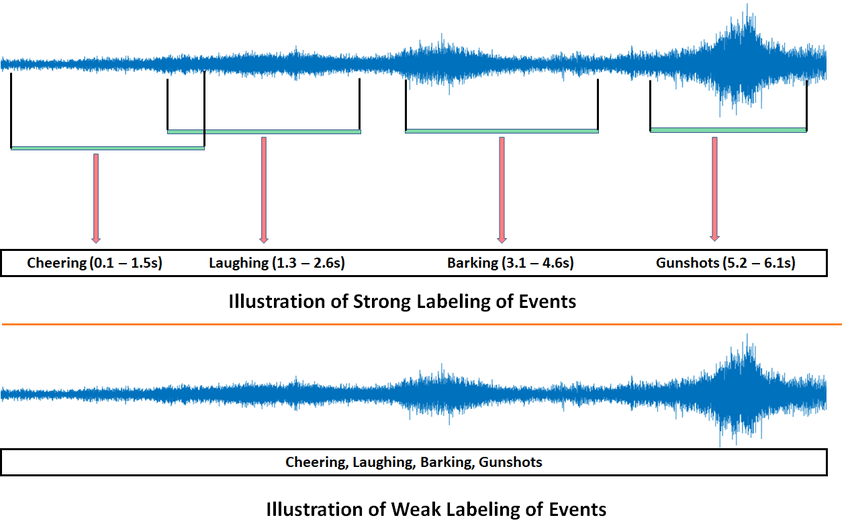


4. This figure gives us an intuitive explanation what is weak annotation and what is strong annotation in terms of sound event detection. For this competition, we only have weak annotation (clip level annotation). Therefore, we need to train our SED model in weakly-supervised manner.

5. In weakly-supervised setting, we only have clip-level annotation, therefore we also need to aggregate that in time axis. Hense, we at first put classifier that outputs class existence probability for each time step just after the feature extractor and then aggregate the output of the classifier result in time axis. In this way we can get both clip-level prediction and segment-level prediction (if the time resolution is high, it can be treated as event-level prediction). Then we train it normally by using BCE loss with clip-level prediction and clip-level annotation.


In [22]:
encoder_params = {
    "tf_efficientnet_b0_ns": {
        "features": 1280,
        "init_op": partial(tf_efficientnet_b0_ns, pretrained=True, drop_path_rate=0.2)
    },
    "tf_efficientnet_b1_ns": {
        "features": 1280,
        "init_op": partial(tf_efficientnet_b1_ns, pretrained=True, drop_path_rate=0.2)
    },
    "tf_efficientnet_b2_ns": {
        "features": 1408,
        "init_op": partial(tf_efficientnet_b2_ns, pretrained=True, drop_path_rate=0.2)
    },
    "tf_efficientnet_b3_ns": {
        "features": 1536,
        "init_op": partial(tf_efficientnet_b3_ns, pretrained=True, drop_path_rate=0.2)
    },
    "tf_efficientnet_b4_ns": {
        "features": 1792,
        "init_op": partial(tf_efficientnet_b4_ns, pretrained=True, drop_path_rate=0.2)
    },
    "tf_efficientnet_b6_ns": {
        "features": 2304,
        "init_op": partial(tf_efficientnet_b6_ns, pretrained=True, drop_path_rate=0.2)
    },
    "mobilenetv3_small_075": {
        "features": 1024,
        "init_op": partial(mobilenetv3_small_075, pretrained=True, drop_path_rate=0)
    },
    "mobilenetv3_small_100": {
        "features": 1024,
        "init_op": partial(mobilenetv3_small_100, pretrained=True, drop_path_rate=0)
    },
    "mobilenetv3_large_075": {
        "features": 1280,
        "init_op": partial(mobilenetv3_large_075, pretrained=True, drop_path_rate=0)
    },
    "mobilenetv3_large_100": {
        "features": 1280,
        "init_op": partial(mobilenetv3_large_100, pretrained=True, drop_path_rate=0)
    },
    "resnest50d": {
        "features": 2048,
        "init_op": partial(resnest50d, pretrained=True, drop_path_rate=0)
    },
    "resnest101e": {
        "features": 2048,
        "init_op": partial(resnest101e, pretrained=True, drop_path_rate=0)
    },
    "resnest200e": {
        "features": 2048,
        "init_op": partial(resnest200e, pretrained=True, drop_path_rate=0)
    },
}

In [23]:
def Model_GlobalPool():
    model = timm.create_model(arquitectura, pretrained=True, in_chans=1, num_classes=0, global_pool='avg')
    return model

class AudioSEDModel(nn.Module):
    def __init__(self, encoder, classes_num):
        super().__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None
        self.interpolate_ratio = 30  # Downsampled ratio

#         # Spectrogram extractor
#         self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
#             win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
#             freeze_parameters=True)

#         # Logmel feature extractor
#         self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
#             n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
#             freeze_parameters=True)

        # Spec augmenter
        # self.spec_augmenter = None 
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
                    freq_drop_width=8, freq_stripes_num=2)
        
#         # Model Encoders
        self.encoder_fft = encoder_params[encoder]["init_op"]()
        self.fce1_fft = nn.Linear(encoder_params[encoder]["features"], 1024, bias=True)
        self.encoder_cqt = encoder_params[encoder]["init_op"]()
        self.fce1_cqt = nn.Linear(encoder_params[encoder]["features"], 1024, bias=True)
    
        self.att_block1 = AttBlock(1024, classes_num, activation="sigmoid")
        self.att_block2 = AttBlock(1024, classes_num, activation="sigmoid")
        
        self.bn0_fft = nn.BatchNorm2d(528)
        self.bn0_cqt = nn.BatchNorm2d(528)
#         self.init_weight()

    def init_weight(self):
        init_layer(self.fc1)
        init_bn(self.bn0_fft)
        init_bn(self.bn0_cqt)
    
    def forward(self, input_fft, input_cqt, mixup_lambda=None):
        """Input : (batch_size, data_length)"""

#         x = self.spectrogram_extractor(input)
        
# #         # --------------------------
# #         # High Contrast!!!
# #         if self.training:
# #             x = random_power(x, power = 2.0, c= 0.5)
# #         else:
# #             x = fixed_power(x, power = 2.0, c= 0.5)
# #         # --------------------------
        
#         # batch_size x 1 x time_steps x freq_bins
#         x = self.logmel_extractor(x)
#         # batch_size x 1 x time_steps x mel_bins


        frames_num = input_fft.shape[2] 
    
        # FFT
        # -----
        input_fft = input_fft.transpose(1, 3)
        input_fft = self.bn0_fft(input_fft)
        input_fft = input_fft.transpose(1, 3)
        

        if self.training:
            input_fft = self.spec_augmenter(input_fft)
        
        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            input_fft = do_mixup(input_fft, mixup_lambda)
        input_fft = input_fft.permute(0,1,3,2)
        input_fft = input_fft.expand(input_fft.shape[0], 3, input_fft.shape[2], input_fft.shape[3])
        input_fft = self.encoder_cqt.forward_features(input_fft)
        input_fft = torch.mean(input_fft, dim=3)
#         print(input_fft.shape)
        
        x1fft = F.max_pool1d(input_fft, kernel_size=3, stride=1, padding=1)
        x2fft = F.avg_pool1d(input_fft, kernel_size=3, stride=1, padding=1)
        xfft = x1fft + x2fft
        xfft = F.dropout(xfft, p=0.5, training=self.training)
        xfft = xfft.transpose(1, 2)
        xfft = F.relu_(self.fce1_fft(xfft))
        xfft = xfft.transpose(1, 2)
        xfft = F.dropout(xfft, p=0.5, training=self.training)
#         print(xfft.shape)   
        
        # CQT
        # ---
        input_cqt = input_cqt.transpose(1, 3)
        input_cqt = self.bn0_cqt(input_cqt)
        input_cqt = input_cqt.transpose(1, 3)
        #print(x.shape)
        if self.training:
            input_cqt = self.spec_augmenter(input_cqt)
        
        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            input_cqt = do_mixup(input_cqt, mixup_lambda)
            
        # Output shape (batch size, channels, time, frequency)
#         input_cqt = input_cqt.expand(x.shape[0], 3, x.shape[2], x.shape[3])
        input_cqt = input_cqt.permute(0,1,3,2)
        input_cqt = input_cqt.expand(input_cqt.shape[0], 3, input_cqt.shape[2], input_cqt.shape[3])
        input_cqt = self.encoder_cqt.forward_features(input_cqt)
        input_cqt = torch.mean(input_cqt, dim=3)
#         print(input_cqt.shape)
        
        x1cqt = F.max_pool1d(input_cqt, kernel_size=3, stride=1, padding=1)
        x2cqt = F.avg_pool1d(input_cqt, kernel_size=3, stride=1, padding=1)
        xcqt = x1cqt + x2cqt
        xcqt = F.dropout(xcqt, p=0.5, training=self.training)
        xcqt = xcqt.transpose(1, 2)
        xcqt = F.relu_(self.fce1_cqt(xcqt))
        xcqt = xcqt.transpose(1, 2)
        xcqt = F.dropout(xcqt, p=0.5, training=self.training)
#         print(xcqt.shape)     
        
        
        (clipwise_output_fft, norm_att_fft, segmentwise_output_fft) = self.att_block1(xfft)
        logitfft = torch.sum(norm_att_fft * self.att_block1.cla(xfft), dim=2)
        segmentwise_outputfft = segmentwise_output_fft.transpose(1, 2)
        # Get framewise output
        framewise_outputfft = interpolate(segmentwise_outputfft,
                                       self.interpolate_ratio)
        framewise_outputfft = pad_framewise_output(framewise_outputfft, frames_num)

        
        (clipwise_output_cqt, norm_att_cqt, segmentwise_output_cqt) = self.att_block2(xcqt)
        logitcqt = torch.sum(norm_att_cqt * self.att_block2.cla(xcqt), dim=2)
        segmentwise_outputcqt = segmentwise_output_cqt.transpose(1, 2)
        
        # Get framewise output
        framewise_outputcqt = interpolate(segmentwise_outputcqt,
                                       self.interpolate_ratio)
        framewise_outputcqt = pad_framewise_output(framewise_outputcqt, frames_num)
        
        framewise_output = torch.maximum(framewise_outputfft, framewise_outputcqt)
        logit = torch.maximum(logitfft, logitcqt)
        clipwise_output = torch.maximum(clipwise_output_fft, clipwise_output_cqt)
        
        output_dict = {
            'framewise_output' : framewise_output,
            'logit' : logit,
            'clipwise_output' : clipwise_output
        }

        return output_dict

        
  

# model = AudioSEDModel('tf_efficientnet_b0_ns', 5).to(device)
# model.train()
# output = model(entrada['img_fft'].to(device).float(), entrada['img_cqt'].to(device).float()) #, mixup_lambda=torch.tensor([0.3,0.4]))
# output['logit']

In [24]:
# def Model_GlobalPool():
#     model = timm.create_model(arquitectura, pretrained=True, in_chans=1, num_classes=0, global_pool='avg')
#     return model

# def Model_Normal():
#     model = timm.create_model(arquitectura, pretrained=True, num_classes=5, in_chans=1)
#     return model

# class AudioSEDModel(nn.Module):
#     def __init__(self, encoder, classes_num):
#         super().__init__()

#         window = 'hann'
#         center = True
#         pad_mode = 'reflect'
#         ref = 1.0
#         amin = 1e-10
#         top_db = None
#         self.interpolate_ratio = 30  # Downsampled ratio

# #         # Spectrogram extractor
# #         self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
# #             win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
# #             freeze_parameters=True)

# #         # Logmel feature extractor
# #         self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
# #             n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
# #             freeze_parameters=True)

#         # Spec augmenter
#         # self.spec_augmenter = None 
#         self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
#                     freq_drop_width=8, freq_stripes_num=2)
        
# #         # Model Encoders
# #         self.encoder_fft = encoder_params[encoder]["init_op"]()
#         self.encoder_fft = Model_Normal()
#         self.fce1_fft = nn.Linear(encoder_params[encoder]["features"], 1024, bias=True)
#         self.encoder_cqt = encoder_params[encoder]["init_op"]()
#         self.fce1_cqt = nn.Linear(encoder_params[encoder]["features"], 1024, bias=True)
    
#         self.att_block1 = AttBlock(1024, classes_num, activation="sigmoid")
#         self.att_block2 = AttBlock(1024, classes_num, activation="sigmoid")
        
#         self.bn0_fft = nn.BatchNorm2d(513)
#         self.bn0_cqt = nn.BatchNorm2d(513)
# #         self.init_weight()

#     def init_weight(self):
#         init_layer(self.fc1)
#         init_bn(self.bn0_fft)
#         init_bn(self.bn0_cqt)
    
#     def forward(self, input_fft, mixup_lambda=None):
#         """Input : (batch_size, data_length)"""

# #         x = self.spectrogram_extractor(input)
        
# # #         # --------------------------
# # #         # High Contrast!!!
# # #         if self.training:
# # #             x = random_power(x, power = 2.0, c= 0.5)
# # #         else:
# # #             x = fixed_power(x, power = 2.0, c= 0.5)
# # #         # --------------------------
        
# #         # batch_size x 1 x time_steps x freq_bins
# #         x = self.logmel_extractor(x)
# #         # batch_size x 1 x time_steps x mel_bins


#         frames_num = input_fft.shape[2] 
    
#         # FFT
#         # -----
# #         input_fft = input_fft.transpose(1, 3)
# #         input_fft = self.bn0_fft(input_fft)
# #         input_fft = input_fft.transpose(1, 3)
        
#         output = self.encoder_fft(input_fft)
# #         print(output.shape)
#         output_dict = {
#             'logit' : output,
#             'clipwise_output' : torch.sigmoid(output)
#         }

#         return output_dict
        

# # #         if self.training:
# # #             input_fft = self.spec_augmenter(input_fft)
        
# # #         # Mixup on spectrogram
# # #         if self.training and mixup_lambda is not None:
# # #             input_fft = do_mixup(input_fft, mixup_lambda)
# #         input_fft = input_fft.permute(0,1,3,2)
# #         input_fft = input_fft.expand(input_fft.shape[0], 3, input_fft.shape[2], input_fft.shape[3])
# #         input_fft = self.encoder_cqt.forward_features(input_fft)
# #         input_fft = torch.mean(input_fft, dim=3)
# # #         print(input_fft.shape)
        
# #         x1fft = F.max_pool1d(input_fft, kernel_size=3, stride=1, padding=1)
# #         x2fft = F.avg_pool1d(input_fft, kernel_size=3, stride=1, padding=1)
# #         xfft = x1fft + x2fft
# #         xfft = F.dropout(xfft, p=0.5, training=self.training)
# #         xfft = xfft.transpose(1, 2)
# #         xfft = F.relu_(self.fce1_fft(xfft))
# #         xfft = xfft.transpose(1, 2)
# #         xfft = F.dropout(xfft, p=0.5, training=self.training)
# # #         print(xfft.shape)   
        
# #         # CQT
# #         # ---
# #         input_cqt = input_cqt.transpose(1, 3)
# #         input_cqt = self.bn0_cqt(input_cqt)
# #         input_cqt = input_cqt.transpose(1, 3)
# #         #print(x.shape)
# #         if self.training:
# #             input_cqt = self.spec_augmenter(input_cqt)
        
# #         # Mixup on spectrogram
# #         if self.training and mixup_lambda is not None:
# #             input_cqt = do_mixup(input_cqt, mixup_lambda)
            
# #         # Output shape (batch size, channels, time, frequency)
# # #         input_cqt = input_cqt.expand(x.shape[0], 3, x.shape[2], x.shape[3])
# #         input_cqt = input_cqt.permute(0,1,3,2)
# #         input_cqt = input_cqt.expand(input_cqt.shape[0], 3, input_cqt.shape[2], input_cqt.shape[3])
# #         input_cqt = self.encoder_cqt.forward_features(input_cqt)
# #         input_cqt = torch.mean(input_cqt, dim=3)
# # #         print(input_cqt.shape)
        
# #         x1cqt = F.max_pool1d(input_cqt, kernel_size=3, stride=1, padding=1)
# #         x2cqt = F.avg_pool1d(input_cqt, kernel_size=3, stride=1, padding=1)
# #         xcqt = x1cqt + x2cqt
# #         xcqt = F.dropout(xcqt, p=0.5, training=self.training)
# #         xcqt = xcqt.transpose(1, 2)
# #         xcqt = F.relu_(self.fce1_cqt(xcqt))
# #         xcqt = xcqt.transpose(1, 2)
# #         xcqt = F.dropout(xcqt, p=0.5, training=self.training)
# # #         print(xcqt.shape)     
        
        
# #         (clipwise_output_fft, norm_att_fft, segmentwise_output_fft) = self.att_block1(xfft)
# #         logitfft = torch.sum(norm_att_fft * self.att_block1.cla(xfft), dim=2)
# #         segmentwise_outputfft = segmentwise_output_fft.transpose(1, 2)
# #         # Get framewise output
# #         framewise_outputfft = interpolate(segmentwise_outputfft,
# #                                        self.interpolate_ratio)
# #         framewise_outputfft = pad_framewise_output(framewise_outputfft, frames_num)

        
# #         (clipwise_output_cqt, norm_att_cqt, segmentwise_output_cqt) = self.att_block2(xcqt)
# #         logitcqt = torch.sum(norm_att_cqt * self.att_block2.cla(xcqt), dim=2)
# #         segmentwise_outputcqt = segmentwise_output_cqt.transpose(1, 2)
        
# #         # Get framewise output
# #         framewise_outputcqt = interpolate(segmentwise_outputcqt,
# #                                        self.interpolate_ratio)
# #         framewise_outputcqt = pad_framewise_output(framewise_outputcqt, frames_num)
        
# #         framewise_output = torch.maximum(framewise_outputfft, framewise_outputcqt)
# #         logit = torch.maximum(logitfft, logitcqt)
# #         clipwise_output = torch.maximum(clipwise_output_fft, clipwise_output_cqt)
        
# #         output_dict = {
# #             'framewise_output' : framewise_output,
# #             'logit' : logit,
# #             'clipwise_output' : clipwise_output
# #         }

# #         return output_dict

        
  
# # model = AudioSEDModel('tf_efficientnet_b0_ns', 4).to(device)
# # model.train()
# # output = model(entrada['img_fft'].to(device).float()) #, mixup_lambda=torch.tensor([0.3,0.4]))
# # output['logit']

# Modelo

In [25]:
# def Model():
#     model = timm.create_model(arquitectura, pretrained=True, num_classes=labels_train.shape[1], in_chans=1)
#     return model
# def Model_Features():
#     model = timm.create_model(arquitectura, pretrained=True, in_chans=1, features_only=True)
#     return model
# def Model_GlobalPool():
#     model = timm.create_model(arquitectura, pretrained=True, in_chans=1, num_classes=0, global_pool='avg')
#     return model

In [26]:
# class ModelDos(nn.Module):
#     def __init__(self):
#         super(ModelDos, self).__init__()
#         self.model1 = Model_GlobalPool()
#         self.model2 = Model_GlobalPool()
#         self.fc1 = nn.Linear(1536, 128)
#         self.fc2 = nn.Linear(1536, 128)
#         self.fc_int = nn.Linear(256, 64)
#         self.fc_out = nn.Linear(64, 4)
        
#     def forward(self, x1, x2):
#         x1 = self.model1(x1)
#         x1 = x1.view(x1.size(0), -1)
#         x1 = F.relu(self.fc1(x1))
# #         print(x1.shape)
#         x2 = self.model2(x2)
#         x2 = x2.view(x2.size(0), -1)
#         x2 = F.relu(self.fc2(x2))
#         # Concatenate in dim1 (feature dimension)
#         x = torch.cat((x1, x2), 1)
#         x = F.relu(self.fc_int(x))
# #         print(x.shape)
#         x = self.fc_out(x)
#         return x

# # modelo_dos = ModelDos()
# # input_fft = entrada['img_fft'].float().to(device)
# # input_cqt = entrada['img_cqt'].float().to(device)
# # modelo_dos(input_fft, input_cqt)

# Funciones Train

In [27]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [28]:
# Para entrenar
def train_epoch(model, loader, criterion, optimizer, scheduler, epoch):
    model.train()
    y_true = []
    y_pred = []
    losses = AverageMeter()
    
    t = tqdm(loader)
    for i, sample in enumerate(t):
        optimizer.zero_grad()
        input_fft = sample['img_fft'].float().to(device)
        input_cqt = sample['img_cqt'].float().to(device)
        target = sample['target'].float().to(device)
        bs = input_fft.size(0)
        with torch.cuda.amp.autocast():
            
#             output = model(input)
#             loss = criterion(output['logit'], target) #BCEWithLogitLoss

            output = model(input_fft, input_cqt)
            max_label = torch.argmax(target,dim=1)
            loss = criterion(output['logit'], max_label)   # CrossEntropyLoss

        if USA_FP16:
            # For FP16
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()
        
        y_true.append(target.cpu().numpy())
        y_pred.append(torch.sigmoid(output['logit']).detach().cpu().numpy())
        losses.update(loss.item(), bs)
        t.set_description(f"Train E:{epoch} - Loss:{losses.avg:0.4f}")
    t.close()
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    return losses.avg, y_true, y_pred

# Para validar o inferencia
def valid_epoch(model, loader, criterion, epoch):
    model.eval()
    y_true = []
    y_pred = []
    losses = AverageMeter()
    with torch.no_grad():
        t = tqdm(loader)
        for i, sample in enumerate(t):
            input_fft = sample['img_fft'].float().to(device)
            input_cqt = sample['img_cqt'].float().to(device)
            
            target = sample['target'].float().to(device)
            bs = input_fft.size(0)
            output = model(input_fft, input_cqt)
            max_label = torch.argmax(target,dim=1)
            loss = criterion(output['logit'], max_label)

            #             output = model(input)
#             loss = criterion(output['logit'], target) #BCEWithLogitLoss

            y_true.append(target.cpu().numpy())
            y_pred.append(torch.sigmoid(output['logit']).detach().cpu().numpy())
            losses.update(loss.item(), bs)
            t.set_description(f"Valid E:{epoch} - Loss:{losses.avg:0.4f}")
        t.close()
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    return losses.avg, y_true, y_pred

# Folds

In [29]:
df_train_unique = df_train[df_train['labels'].astype(str)!='[]'].reset_index(drop=True)
df_train_unique['labels'] = df_train_unique['labels'].astype(str)
df_train_unique2 = df_train_unique.groupby('namefile')['labels'].value_counts()
df_train_unique2 = pd.DataFrame(df_train_unique2.groupby('namefile').apply(lambda x: len(x))).reset_index(drop=False)
df_train_unique2.loc[df_train_unique2.labels>3, 'labels'] = 3

In [30]:
df_train_unique2.head()

,namefile,labels
0,012213d40662f86e8f775379bbf94dec,1
1,0159af9f3ca04ada46f0c353ac210bb8,2
2,0271a0818427d7fae7afde67bf49ba30,1
3,035195366b6849c1b339cff8e6de574a,3
4,0389792d2f422f25f5d9abd7e7a308d1,2


In [31]:
df_train_unique2.head()


,namefile,labels
0,012213d40662f86e8f775379bbf94dec,1
1,0159af9f3ca04ada46f0c353ac210bb8,2
2,0271a0818427d7fae7afde67bf49ba30,1
3,035195366b6849c1b339cff8e6de574a,3
4,0389792d2f422f25f5d9abd7e7a308d1,2


In [32]:
seed_everything(SEED)
#     MultilabelStratifiedKFold
#     StratifiedKFold
kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
df_train_unique2['kfold'] = -1
for fold, (t_idx, v_idx) in enumerate(kfold.split(df_train_unique2)):
    df_train_unique2.loc[v_idx, "kfold"] = fold
df_train_unique2.head()

# for fold in range(NUM_FOLDS):
#     print('\nDISTRIBUCION PARA FOLD:',fold)
#     print(pd.DataFrame([df_train_unique2[df_train_unique2.kfold!=0]['labels'].astype(str).value_counts()[:10]/(df_train_unique2.kfold!=0).sum(),
#                   df_train_unique2[df_train_unique2.kfold==0]['labels'].astype(str).value_counts()[:10]/(df_train_unique2.kfold==0).sum()]))

,namefile,labels,kfold
0,012213d40662f86e8f775379bbf94dec,1,3
1,0159af9f3ca04ada46f0c353ac210bb8,2,7
2,0271a0818427d7fae7afde67bf49ba30,1,6
3,035195366b6849c1b339cff8e6de574a,3,9
4,0389792d2f422f25f5d9abd7e7a308d1,2,7


#  Valid Database

In [33]:
df.head()

,path,start,duration,end,label,len_audio,sr_audio,seconds_audio,dir,clase,pos_ini,pos_fin,clase_num
0,012213d40662f86e8f775379bbf94dec,61.186,2.500,63.686,whistle,14700000,50000,294.0,../input/datathon2022/dataset1/012213d40662f86...,whistle,3059300.0,3184300.0,0
1,0159af9f3ca04ada46f0c353ac210bb8,76.260,17.000,93.260,cetaceans_allfreq,14700000,50000,294.0,../input/datathon2022/dataset1/0159af9f3ca04ad...,cetaceans_allfreq,3813000.0,4663000.0,2
2,0159af9f3ca04ada46f0c353ac210bb8,161.482,1.000,162.482,click,14700000,50000,294.0,../input/datathon2022/dataset1/0159af9f3ca04ad...,click,8074100.0,8124100.0,1
3,0271a0818427d7fae7afde67bf49ba30,91.563,1.000,92.563,click,14700000,50000,294.0,../input/datathon2022/dataset1/0271a0818427d7f...,click,4578150.0,4628150.0,1
4,0271a0818427d7fae7afde67bf49ba30,125.627,1.316,126.943,click,14700000,50000,294.0,../input/datathon2022/dataset1/0271a0818427d7f...,click,6281350.0,6347150.0,1


In [34]:
df_para_sed = df.copy()
df_para_sed['kfold'] = df_para_sed['path'].map(dict(zip(df_train_unique2['namefile'], df_train_unique2.kfold)))
df_para_sed.head()

,path,start,duration,end,label,len_audio,sr_audio,seconds_audio,dir,clase,pos_ini,pos_fin,clase_num,kfold
0,012213d40662f86e8f775379bbf94dec,61.186,2.500,63.686,whistle,14700000,50000,294.0,../input/datathon2022/dataset1/012213d40662f86...,whistle,3059300.0,3184300.0,0,3.0
1,0159af9f3ca04ada46f0c353ac210bb8,76.260,17.000,93.260,cetaceans_allfreq,14700000,50000,294.0,../input/datathon2022/dataset1/0159af9f3ca04ad...,cetaceans_allfreq,3813000.0,4663000.0,2,7.0
2,0159af9f3ca04ada46f0c353ac210bb8,161.482,1.000,162.482,click,14700000,50000,294.0,../input/datathon2022/dataset1/0159af9f3ca04ad...,click,8074100.0,8124100.0,1,7.0
3,0271a0818427d7fae7afde67bf49ba30,91.563,1.000,92.563,click,14700000,50000,294.0,../input/datathon2022/dataset1/0271a0818427d7f...,click,4578150.0,4628150.0,1,6.0
4,0271a0818427d7fae7afde67bf49ba30,125.627,1.316,126.943,click,14700000,50000,294.0,../input/datathon2022/dataset1/0271a0818427d7f...,click,6281350.0,6347150.0,1,6.0


In [35]:
# valid_df = df_para_sed[df_para_sed['kfold'] == 0].reset_index(drop=True)
# valid_df.shape

df_valid_unique = df_para_sed[df_para_sed['kfold'] == 0].reset_index(drop=True)
df_valid_unique = df_valid_unique[['path','dir']].drop_duplicates().reset_index(drop=True)

step_audio = int(tramo_length * 50000) 
win_ancho = int(tramo_length * 50000)
valid_df = []
for nrow, row in tqdm(df_valid_unique.iterrows(), total=len(df_valid_unique)):
    for pos_ini in np.arange(0,14700000-step_audio,step_audio):
        pos_fin = pos_ini + win_ancho
        if pos_fin > 14700000:
            break
        valid_df.append(dict(path=row['path'],
                                dir=row['dir'],
                                start=float(pos_ini/50000),
                                end=float(pos_fin/50000),
                                pos_ini=pos_ini,
                                pos_fin=pos_fin,
                             label = None,
                                len_audio=14700000))
valid_df = pd.DataFrame(valid_df)
print(valid_df.shape)
valid_df['duracion'] = valid_df['pos_fin'] - valid_df['pos_ini']
valid_df.tail()

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1286.84it/s]

(5840, 8)


,path,dir,start,end,pos_ini,pos_fin,label,len_audio,duracion
5835,fbe1e8a69790ec793529451f119cc1ee,../input/datathon2022/dataset1/fbe1e8a69790ec7...,282.0,284.0,14100000,14200000,None,14700000,100000
5836,fbe1e8a69790ec793529451f119cc1ee,../input/datathon2022/dataset1/fbe1e8a69790ec7...,284.0,286.0,14200000,14300000,None,14700000,100000
5837,fbe1e8a69790ec793529451f119cc1ee,../input/datathon2022/dataset1/fbe1e8a69790ec7...,286.0,288.0,14300000,14400000,None,14700000,100000
5838,fbe1e8a69790ec793529451f119cc1ee,../input/datathon2022/dataset1/fbe1e8a69790ec7...,288.0,290.0,14400000,14500000,None,14700000,100000
5839,fbe1e8a69790ec793529451f119cc1ee,../input/datathon2022/dataset1/fbe1e8a69790ec7...,290.0,292.0,14500000,14600000,None,14700000,100000


In [36]:
df_para_sed.label.value_counts()

whistle              2848
click                2077
cetaceans_allfreq     475
allfreq                23
Name: label, dtype: int64

# Entrenamiento

In [37]:
# GPU con 8 Gigas
BATCH_TRAIN = 8 #10
NUM_WORKERS = 8
BATCH_VALID = BATCH_TRAIN
BATCH_TEST = BATCH_TRAIN

# --------------------------------------
# Parametros para optimizar con 'CosineAnnealingWarmUpRestarts'
LR = 1e-5 #Learning rate
T_MULT = 1 # Factor multiplicador de  la longitud del siguiente ciclo
ETA_MAX = 0.001  #0.002 0.001 # Valor maximo LR
EPOCHS_UP = 5 # Epochs ciclo de subida  EPOCHS_CYCLE//4
NUM_EPOCHS = 40 # Max epochs
EPOCHS_CYCLE = NUM_EPOCHS #Epochs ciclo completo EPOCHS//(1+T_MULT+(T_MULT*T_MULT))
# Num iters per epoch len of (num_folds-1) trainning DB / BATCH_SIZE

ITERS_EPOCH = int(300 // BATCH_TRAIN) #*(NUM_FOLDS-1) // (BATCH_TRAIN*(NUM_FOLDS)) #Calcula los iters por epoch
# ITERS_EPOCH = int(len(df_para_sed.query('kfold > 2')) // (BATCH_TRAIN)) #Calcula los iters por epoc
print(ITERS_EPOCH, EPOCHS_UP, NUM_EPOCHS)

GAMMA = 0.90 # Factor reductor del maximo de cada ciclo
# -------------------------------------
EARLY_STOP = 9999 # Numero de epochs para si no mejora


# output_dir = create_output_dir(display=True, create=True, dirbase = 'resultados')
# output_dir = Path('resultados/0049_model/')
output_dir = Path('')
str(output_dir)


37 5 40


'.'

In [38]:
# df_para_sed[df_para_sed['kfold'] >= 2].reset_index(drop=True).shape

In [39]:
if ENTRENA:
    start = time.time()
    # Base de datos de entrenamiento y validacion
    # --------------------------------------------
    trues_total = []
    preds_total = []
    for fold in [0]: #range(NUM_FOLDS):
        print('FOLD:',fold)
        # valid_df = df_para_sed[df_para_sed['kfold'] == 0].reset_index(drop=True)
        test_df = df_para_sed[df_para_sed['kfold'] == 1].reset_index(drop=True)
        train_df = df_para_sed[df_para_sed['kfold'] >= 2].reset_index(drop=True) #Añadimos la BD de testeo

        print(train_df.shape, valid_df.shape) #, test_df.shape)
        
        # Modelo y optimizacion
        # ---------------------
#         model = ModelDos().to(device)
        model = AudioSEDModel('tf_efficientnet_b6_ns', 5)
#         model.load_state_dict(torch.load('resultados/0048_model/modelo_fold-0.bin'))
        model = model.to(device)

        # optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        # https://pythonawesome.com/a-collection-of-optimizers-for-pytorch/
        optimizer = optim.DiffGrad(model.parameters(), lr=LR)
        if USA_FP16:
            scaler = torch.cuda.amp.GradScaler()
            
        scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=ITERS_EPOCH*EPOCHS_CYCLE, T_mult=T_MULT, 
                                          eta_max=ETA_MAX, T_up=ITERS_EPOCH*EPOCHS_UP, gamma=GAMMA)
        # scheduler = None
        criterion = nn.CrossEntropyLoss()
#         criterion = nn.BCEWithLogitsLoss() # Multilabel

    
        # train loader
        # ------------
        trainset = SedDataset(df=train_df, eventos=eventos, audio_transform=None,  modo="train")
                              #         audio_transform=train_audio_transform,
        train_loader = DataLoader(trainset, batch_size=BATCH_TRAIN, shuffle=True, drop_last=False) #, num_workers=NUM_WORKERS)
            
        # valid loader
        # ------------
        validset = SedDataset(df=valid_df, eventos=eventos, audio_transform=None,  modo="valid")
        valid_loader = DataLoader(validset, batch_size=BATCH_VALID, shuffle=False, drop_last=False) #, num_workers=NUM_WORKERS)

        # Inicializamos variables
        # -----------------------
        best_auc = 0
        best_acc = 0
        best_f1_micro = 0
        best_f1_macro = 0
        best_f1_weighted = 0
        best_epoch = 0
        best_loss = np.inf
        early_stop_count = 0
        res = []
        best_preds_fold = []
        best_trues_fold = []  
        best_thr = [0.0, 0.0, 0.0, 0.0, 0.0]

        # Bucle principal
        # ---------------
#             whistle              2848
#             click                2077
#             cetaceans_allfreq     475
#             allfreq                23
        
        for epoch in range(NUM_EPOCHS):
            seed_everything(SEED*(epoch+1))
            ttt1 = train_df.query('label=="whistle"').sample(75).reset_index(drop=True)
            ttt2 = train_df.query('label=="click"').sample(75).reset_index(drop=True)
            ttt3 = train_df.query('label=="cetaceans_allfreq"').sample(75).reset_index(drop=True)
            ttt4 = train_df.query('label=="allfreq"').sample(75, replace=True).reset_index(drop=True)
            
            trainset = SedDataset(df=pd.concat([ttt1,ttt2,ttt3,ttt4]).reset_index(drop=True), 
                                  eventos=eventos, audio_transform=None,  modo="train")
            train_loader = DataLoader(trainset, batch_size=BATCH_TRAIN, shuffle=True, drop_last=False)
        
            
#             # train loader
#             # ------------
#             train_df_nolabels_idx = train_df[no_labels_in_train].index
#             train_df_labels_idx = train_df[~no_labels_in_train].index
#             train_df_nolabels_idx_sample = np.random.choice(train_df_nolabels_idx,NUM_NO_EVENT, replace=False)
#             train_df_combi = pd.concat([train_df.iloc[train_df_labels_idx], 
#                                         train_df.iloc[train_df_nolabels_idx_sample]]).reset_index(drop=True)
#             train_labels_combi = pd.concat([train_labels.iloc[train_df_labels_idx], 
#                                             train_labels.iloc[train_df_nolabels_idx_sample]]).reset_index(drop=True)
            
#             trainset = SedDataset(df=train_df_combi, labels=train_labels_combi, audio_transform=None,  modo="train")
#                                   #         audio_transform=train_audio_transform,
#             train_loader = DataLoader(trainset, batch_size=BATCH_TRAIN, shuffle=True, drop_last=False, num_workers=NUM_WORKERS)
        
            start_epoch = time.time()
            warnings.filterwarnings('ignore')
            train_loss, y_true_train, y_pred_train = train_epoch(model, train_loader, criterion, optimizer, scheduler, epoch)
            warnings.filterwarnings('ignore')
            valid_loss, y_true_valid, y_pred_valid = valid_epoch(model, valid_loader, criterion, epoch)
            
            
#             final_loss = criterion(torch.tensor(y_pred_valid), torch.argmax(torch.tensor(y_true_valid),dim=1))
            valid_auc = mean_auc(y_true_valid, y_pred_valid)
            valid_acc = np.mean(np.argmax(y_true_valid,1)==np.argmax(y_pred_valid,1))
            f1_micro = metrics.f1_score(np.argmax(y_true_valid,1), np.argmax(y_pred_valid,1), average='micro')
            f1_macro = metrics.f1_score(np.argmax(y_true_valid,1), np.argmax(y_pred_valid,1), average='macro')
            f1_weighted = metrics.f1_score(np.argmax(y_true_valid,1), np.argmax(y_pred_valid,1), average='weighted')


             # valid_auc = mean_auc(y_true_valid, y_pred_valid)
#             valid_acc = np.mean((y_true_valid.flatten()>0.50)==(y_pred_valid.flatten()>0.50))
            # # f1_micro = metrics.f1_score(y_true_valid>0.50, y_pred_valid>0.50, average='micro')
            # f1_macro = metrics.f1_score(y_true_valid>0.50, y_pred_valid>0.50, average='macro')
            # f1_weighted = metrics.f1_score(y_true_valid>0.50, y_pred_valid>0.50, average='weighted')

            
#             numero_en_valid = best_trues_fold.sum(axis=0)
#             best_thr_val = np.array([0.0, 0.0, 0.0, 0.0])
#             for nclase in range(4):
#                 diff_total=999999
#                 for thr in np.linspace(0.0,1.0,1000):
#                     dif_num = np.abs(numero_en_valid[nclase]-(preds_fragments_cp_val[:,nclase].flatten()>thr).sum())
#                     if dif_num < diff_total:
#                         # print(thr, dif_num)
#                         diff_total = dif_num
#                         best_thr_val[nclase] = thr

#             print(best_thr_val)
#             (preds_fragments_cp_val>np.array(best_thr_val)).sum(axis=0)


#             # Obtain best f1macro
#             # y_pred_valid_cp = np.vstack([i for i in y_pred_valid])
#             # y_true_valid_cp = np.vstack([i for i in y_true_valid])
#             y_pred_valid_cp = y_pred_valid.copy()
#             y_true_valid_cp = y_true_valid.copy()

#             y_pred_valid_labels = (y_pred_valid_cp>0.50)
#             y_true_valid_labels = (y_true_valid_cp>0.50)

#             best_thr = [0.0, 0.0, 0.0, 0.0]
#             for ncol in tqdm(range(4)):
#                 f1_col = 0
#                 for thr_col in np.linspace(0,0.99,100):
#                     y_pred_valid_labels[:,ncol] = y_pred_valid_cp[:,ncol]>thr_col
#                     f1_tmp = metrics.f1_score(y_true_valid_labels[:,ncol].flatten(), 
#                                               y_pred_valid_labels[:,ncol].flatten())
#                     if f1_tmp>f1_col:
#                         f1_col = f1_tmp
#                         best_thr[ncol] = thr_col

#             for ncol, thr_col in enumerate(best_thr):
#                 y_pred_valid_labels[:,ncol] = y_pred_valid_cp[:,ncol]>thr_col

#             f1_micro = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='micro')
#             f1_macro = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='macro')
#             f1_weighted = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='weighted')

#             f1_col = 0
#             for thr_col1 in tqdm(np.linspace(0,0.90,41)):
#                 for thr_col2 in np.linspace(0,0.90,41):
#                     for thr_col3 in np.linspace(0,0.90,41):
#                         y_pred_valid_labels[:,0] = y_pred_valid_cp[:,0]>thr_col1
#                         y_pred_valid_labels[:,1] = y_pred_valid_cp[:,1]>thr_col2
#                         y_pred_valid_labels[:,2] = y_pred_valid_cp[:,2]>thr_col3
#                         f1_tmp = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='micro')
#                         if f1_tmp>f1_col:
#                             best_thr = [thr_col1, thr_col2, thr_col3]
#                             f1_col = f1_tmp

#             for ncol, thr_col in enumerate(best_thr):
#                 y_pred_valid_labels[:,ncol] = y_pred_valid_cp[:,ncol]>thr_col
                
#             f1_micro = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='micro')
#             f1_macro = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='macro')
#             f1_weighted = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='weighted')
            
            tiempo = round(((time.time() - start)/60),2)
            tiempo_epoch = round(((time.time() - start_epoch)/60),2)
#             clear_output(wait=True) #para limpiar warnings
            print(f'Epoch={epoch:02d} TrainLOSS={train_loss:.04f}\tValidLOSS={valid_loss:.04f}  ValidACC={valid_acc:.04f}  ValidAUC={valid_auc:0.4f}')
            print(f'\t\t\t f1_micro={f1_micro:.04f}  f1_macro={f1_macro:.04f}  f1_weighted={f1_weighted:0.4f}')
            print(f'BestE={best_epoch:02d} min={tiempo_epoch:.01f}/{tiempo:.01f}\tBest_LOSS={best_loss:.04f}  Best_ACC={best_acc:.04f}  Best_AUC={best_auc:.04f}')
            print(f'\t\t\t best_f1_micro={best_f1_micro:.04f}  best_f1_macro={best_f1_macro:.04f}  best_f1_weighted={best_f1_weighted:0.4f}')

            # Guarda mejor modelo y mejores resultados
            # ----------------------------------------
            
            if f1_micro > best_f1_micro:
                print(f"########## >>>>>>>> Model Mejorado de loss={best_f1_micro} ----> loss=={f1_micro}")
                # print(f"########## >>>>>>>> Model Mejorado de loss={best_auc} ----> loss=={valid_auc}")
            
#             if valid_loss < best_loss:
#                 print(f"########## >>>>>>>> Model Mejorado de loss={best_loss} ----> loss=={valid_loss}")
                
                torch.save(model.state_dict(), output_dir / f'modelo_fold-{fold}.bin')
                best_epoch = epoch
                best_loss = valid_loss
                best_acc = valid_acc
                best_auc = valid_auc
                best_f1_micro = f1_micro
                best_f1_macro = f1_macro
                best_f1_weighted = f1_weighted
                best_thr_all = best_thr.copy()
                early_stop_count = 0
                best_preds_fold = y_pred_valid
                best_trues_fold = y_true_valid
            else:
                early_stop_count += 1

            # Guarda resultados del epoch
            # ---------------------------
            if scheduler.__class__ ==  torch.optim.lr_scheduler.OneCycleLR:
                lr = scheduler.get_last_lr()[0]
            else:
                lr = optimizer.param_groups[0]['lr']

            res.append(dict({'epoch':epoch, 'lr':lr, 'tiempo':tiempo,
                             'trn_loss':train_loss, 'val_loss':valid_loss, 
                             'val_acc':valid_acc, 'val_auc':valid_auc,
                             'f1_micro':f1_micro, 'f1_macro':f1_macro, 'f1_weighted':f1_weighted,
                             'best_epoch':best_epoch, 'best_loss':best_loss,
                             'best_acc':best_acc, 'best_auc':best_auc,
                             'best_f1_micro':best_f1_micro, 'best_f1_macro':best_f1_macro, 'best_f1_weighted':best_f1_weighted,
                             }))
            res_df = pd.DataFrame(res)
            res_df.to_csv(output_dir / f'modelo_fold-{fold}.csv')

            # Guarda predicciones
            # -------------------
            with open(output_dir / f'modelo_fold-{fold}.pkl', 'wb') as file:
                pickle.dump(best_preds_fold, file)
                pickle.dump(best_trues_fold, file)

            # Dibuja graficos
            # ---------------
            fig, axs = plt.subplots(2,2, figsize=(15,15))
            axs[0,0].plot(res_df['trn_loss'].values, label='trn_loss')
            axs[0,0].plot(res_df['val_loss'].values, label='val_loss')
            axs[0,0].set_xlabel('Epochs')
            axs[0,0].set_ylabel('Loss')
            axs[0,0].set_title(f'Val_loss={valid_loss:.6f} Best={best_loss:.6f} in Epoch{best_epoch}')
            axs[0,0].legend(loc='upper right')

            axs[0,1].plot(res_df['val_acc'].values, label='val_acc')
            axs[0,1].plot(res_df['f1_micro'].values, label='f1_micro')
#             axs[0,1].plot(res_df['f1_macro'].values, label='f1_macro')
    #         axs[0,1].plot(res_df['f1_weighted'].values, label='f1_weighted')
            axs[0,1].set_xlabel('Epochs')
            axs[0,1].set_ylabel('Acc y f1micro')
    #         axs[0,1].set_title(f'ACC={valid_acc:.3f},fmic={f1_micro:.3f},fmac={f1_macro:.3f} fweig={f1_weighted:.3f} Best[ACC={best_acc:.3f},fmic={best_f1_micro:.3f},fmac={best_f1_macro:.3f},fweig={best_f1_weighted:.3f} Epoch{best_epoch}]')
            axs[0,1].set_title(f'ACC={valid_acc:.4f} fmic={f1_micro:.5f} Best:[ACC={best_acc:.4f} fmic={best_f1_micro:.5f}')
            axs[0,1].legend(loc='lower right')

            axs[1,0].plot(res_df['val_auc'].values, label='auc')
            axs[1,0].set_xlabel('Epochs')
            axs[1,0].set_ylabel('AUC MEAN')
            axs[1,0].set_title(f'AUC={valid_auc:.6f} BestAUC={best_auc:.6f} in Epoch{best_epoch}')

            axs[1,1].plot(res_df['lr'].values)
            axs[1,1].set_xlabel('Epochs')
            axs[1,1].set_ylabel('Learning Rate')
            axs[1,1].set_title(f'Learning Rate={lr:.8f} Max={res_df.lr.max():.8f} Min={res_df.lr.min():.8f}')
            fig.savefig(output_dir / f'modelo_fold-{fold}.png',facecolor='white', edgecolor='white')
            plt.close(fig)

            # Si se alcanza parada temprana sal
            # ---------------------------------
            if EARLY_STOP == early_stop_count:
                print('\n !!! ALCANZADO EARLY STOPPING EN EL EPOCH:', epoch, '!!! MEJOR MODELO EN EPOCH:', best_epoch)
                break
        trues_total.append(best_trues_fold)
        preds_total.append(best_preds_fold)

    best_trues_fold = np.vstack(trues_total)
    best_preds_fold = np.vstack(preds_total)

# Sacamos Thresholds con Test

In [40]:
# df_test_unique = df_para_sed[df_para_sed['kfold'] == 1].reset_index(drop=True)
# df_test_unique = df_test_unique[['path','dir']].drop_duplicates().reset_index(drop=True)

# step_audio = int(tramo_length * 50000) 
# win_ancho = int(tramo_length * 50000)
# test_df = []
# for nrow, row in tqdm(df_test_unique.iterrows(), total=len(df_test_unique)):
#     for pos_ini in np.arange(0,14700000-step_audio,step_audio):
#         pos_fin = pos_ini + win_ancho
#         if pos_fin > 14700000:
#             break
#         test_df.append(dict(path=row['path'],
#                                 dir=row['dir'],
#                                 start=float(pos_ini/50000),
#                                 end=float(pos_fin/50000),
#                                 pos_ini=pos_ini,
#                                 pos_fin=pos_fin,
#                             label = None,
#                                 len_audio=14700000))
# test_df = pd.DataFrame(test_df)
# print(test_df.shape)
# test_df['duracion'] = test_df['pos_fin'] - test_df['pos_ini']
# test_df.tail()

In [41]:
# model = AudioSEDModel('tf_efficientnet_b6_ns', 5).to(device)
# model.load_state_dict(torch.load(output_dir / f'modelo_fold-{fold}.bin'))
# model = model.to(device)

# warnings.filterwarnings('ignore')
# testset = SedDataset(df=test_df, eventos=eventos, audio_transform=None,  modo="valid")
# test_loader = DataLoader(testset, batch_size=BATCH_VALID, shuffle=False, drop_last=False) #, num_workers=NUM_WORKERS)
# test_loss, y_true_test, y_pred_test = valid_epoch(model, test_loader, criterion, epoch)

In [42]:
# test_loss

In [43]:
# for nini in np.arange(0,len(y_pred_test),100):
#     clear_output()
#     fig, ax = plt.subplots(2,1)
#     ax[0].plot(y_pred_test[nini:nini+100,:5])
#     ax[1].plot(y_true_test[nini:nini+100,:5])
#     print(nini*50000*2.0)
#     plt.show()
#     input('press a key')

In [44]:
# y_pred_test_cp = y_pred_test.copy()

In [45]:
# y_pred_test = F.softmax(torch.from_numpy(y_pred_test_cp)).numpy()

In [46]:
# valid_auc = mean_auc(y_true_test, y_pred_test)
# valid_acc = np.mean(np.argmax(y_true_test,1)==np.argmax(y_pred_test,1))
# f1_micro = metrics.f1_score(np.argmax(y_true_test,1), np.argmax(y_pred_test,1), average='micro')
# f1_macro = metrics.f1_score(np.argmax(y_true_test,1), np.argmax(y_pred_test,1), average='macro')
# f1_weighted = metrics.f1_score(np.argmax(y_true_test,1), np.argmax(y_pred_test,1), average='weighted')
# print(f'f1_micro={f1_micro:.04f}  f1_macro={f1_macro:.04f}  f1_weighted={f1_weighted:0.4f}')
# print(f'ValidACC={valid_acc:.04f}  ValidAUC={valid_auc:0.4f}')          

In [47]:
# f1_micro = metrics.f1_score(np.argmax(y_true_test[:,:4],1), np.argmax(y_pred_test[:,:4],1), average='micro')
# f1_macro = metrics.f1_score(np.argmax(y_true_test[:,:4],1), np.argmax(y_pred_test[:,:4],1), average='macro')
# f1_weighted = metrics.f1_score(np.argmax(y_true_test[:,:4],1), np.argmax(y_pred_test[:,:4],1), average='weighted')
# print(f'f1_micro={f1_micro:.04f}  f1_macro={f1_macro:.04f}  f1_weighted={f1_weighted:0.4f}')

In [48]:
# y_pred_valid_cp = y_pred_test.copy() #np.vstack([i for i in best_preds_fold])
# y_true_valid_cp = y_true_test.copy() #np.vstack([i for i in best_trues_fold])

# #             y_pred_valid_cp = y_pred_valid.copy()
# y_pred_valid_labels = (y_pred_valid_cp>0.50).astype(int)
# y_true_valid_labels = (y_true_valid_cp>0.50).astype(int)

# best_thr = [1.0, 1.0, 1.0, 1.0, 1.0]
# for ncol in tqdm(range(5)):
#     f1_col = 0
#     for thr_col in np.linspace(0,0.99,1000):
#         y_pred_valid_labels[:,ncol] = y_pred_valid_cp[:,ncol]>thr_col
# #         TP = ((y_true_valid_labels[:,ncol].flatten()+y_pred_valid_labels[:,ncol].flatten())==2).sum()
# #         FP = ((y_true_valid_labels[:,ncol].flatten()-y_pred_valid_labels[:,ncol].flatten())== -1).sum()
# #         FN = ((y_true_valid_labels[:,ncol].flatten()-y_pred_valid_labels[:,ncol].flatten())== 1).sum()
# #         f1_tmp = TP / (TP+(0.50*(FP+FN)))
        
#         f1_tmp = metrics.f1_score(y_true_valid_labels[:,ncol].flatten(), 
#                                   y_pred_valid_labels[:,ncol].flatten())
#         if f1_tmp>f1_col:
#             f1_col = f1_tmp
#             best_thr[ncol] = thr_col
            
# for ncol, thr_col in enumerate(best_thr):
#     y_pred_valid_labels[:,ncol] = y_pred_valid_cp[:,ncol]>thr_col

# f1_micro = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='micro')
# f1_macro = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='macro')
# f1_weighted = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='weighted')

# print(len(y_pred_valid_labels), best_thr)
# print(f1_micro, f1_macro, f1_weighted)
# print(y_pred_valid_labels.sum(axis=0), (y_true_valid_labels.sum(axis=0)))
# best_thr_tst = best_thr

In [49]:
# best_preds_fold_cp = best_preds_fold.copy()

In [50]:
# best_preds_fold = F.softmax(torch.from_numpy(best_preds_fold_cp)).numpy()

In [51]:
# y_pred_valid_cp = best_preds_fold.copy() #np.vstack([i for i in best_preds_fold])
# y_true_valid_cp = best_trues_fold.copy() #np.vstack([i for i in best_trues_fold])

# #             y_pred_valid_cp = y_pred_valid.copy()
# y_pred_valid_labels = (y_pred_valid_cp>0.50).astype(int)
# y_true_valid_labels = (y_true_valid_cp>0.50).astype(int)

# best_thr = [1.0, 1.0, 1.0, 1.0, 1.0]
# for ncol in tqdm(range(5)):
#     f1_col = 0
#     for thr_col in np.linspace(0,0.99,1000):
#         y_pred_valid_labels[:,ncol] = y_pred_valid_cp[:,ncol]>thr_col
# #         TP = ((y_true_valid_labels[:,ncol].flatten()+y_pred_valid_labels[:,ncol].flatten())==2).sum()
# #         FP = ((y_true_valid_labels[:,ncol].flatten()-y_pred_valid_labels[:,ncol].flatten())== -1).sum()
# #         FN = ((y_true_valid_labels[:,ncol].flatten()-y_pred_valid_labels[:,ncol].flatten())== 1).sum()
# #         f1_tmp = TP / (TP+(0.50*(FP+FN)))
        
#         f1_tmp = metrics.f1_score(y_true_valid_labels[:,ncol].flatten(), 
#                                   y_pred_valid_labels[:,ncol].flatten())
#         if f1_tmp>f1_col:
#             f1_col = f1_tmp
#             best_thr[ncol] = thr_col
            
# for ncol, thr_col in enumerate(best_thr):
#     y_pred_valid_labels[:,ncol] = y_pred_valid_cp[:,ncol]>thr_col

# f1_micro = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='micro')
# f1_macro = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='macro')
# f1_weighted = metrics.f1_score(y_true_valid_labels, y_pred_valid_labels, average='weighted')

# print(len(y_pred_valid_labels), best_thr)
# print(f1_micro, f1_macro, f1_weighted)
# print(y_pred_valid_labels.sum(axis=0), (y_true_valid_labels.sum(axis=0)))
# best_thr_val = best_thr

# Sacamos la Submission

In [52]:
# Bucle para inferencia
def submission_epoch(model, loader):
    model.eval()
    y_pred = []
#     y_frame = []
    with torch.no_grad():
        for sample in tqdm(loader):
            input_fft = sample['img_fft'].float().to(device)
            input_cqt = sample['img_cqt'].float().to(device)
            bs = input_fft.size(0)
            output = model(input_fft, input_cqt)
#             output = model(input_fft)
            y_pred.append(torch.sigmoid(output['logit']).detach().cpu().numpy())  
#             y_frame.append(output['framewise_output'].detach().cpu().numpy())
            
    y_pred = np.vstack(y_pred)
#     y_frame = np.vstack(y_frame)
#     return y_pred, y_frame
    return y_pred

In [53]:
archivos_submission = os.listdir('../input/datathon2022/dataset1/submission/')
len_audio = []
sr_audio = []
seconds_audio = []
df_sub = pd.DataFrame({'path':[i.split('.')[0] for i in archivos_submission]})
for name_file in tqdm(df_sub.path):
    y, sr = sf.read(f'../input/datathon2022/dataset1/submission/{name_file}.wav')
    len_audio.append(len(y))
    sr_audio.append(sr)
    seconds_audio.append(len(y)/sr)
df_sub['len_audio'] = len_audio
df_sub['sr_audio'] = sr_audio
df_sub['seconds_audio'] = seconds_audio
df_sub['dir'] = ['../input/datathon2022/dataset1/submission/'+i+'.wav' for i in df_sub['path']]
df_sub.shape

100%|███████████████████████████████████████████| 70/70 [00:01<00:00, 35.56it/s]


(70, 5)

In [54]:
step_audio = int(tramo_length * 50000) 
win_ancho = int(tramo_length * 50000)
db_sub_troceada = []
for nrow, row in tqdm(df_sub.iterrows(),total=len(df_sub)):
    for pos_ini in np.arange(0,14700000-step_audio,step_audio):
        pos_fin = pos_ini + win_ancho
        if pos_fin > 14700000:
            break
        db_sub_troceada.append(dict(path=row['path'],
                                dir=row['dir'],
                                start=float(pos_ini/50000),
                                end=float(pos_fin/50000),
                                pos_ini=pos_ini,
                                pos_fin=pos_fin,
                                    label=None,
                                len_audio=14700000))
db_sub_troceada = pd.DataFrame(db_sub_troceada)
print(db_sub_troceada.shape)
db_sub_troceada['duracion'] = db_sub_troceada['pos_fin'] - db_sub_troceada['pos_ini']
print(db_sub_troceada.duracion.unique())
db_sub_troceada.tail()

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 1312.47it/s]

(10220, 8)
[100000]


,path,dir,start,end,pos_ini,pos_fin,label,len_audio,duracion
10215,01767f8a26ee7958bdaad80f50f21873,../input/datathon2022/dataset1/submission/0176...,282.0,284.0,14100000,14200000,None,14700000,100000
10216,01767f8a26ee7958bdaad80f50f21873,../input/datathon2022/dataset1/submission/0176...,284.0,286.0,14200000,14300000,None,14700000,100000
10217,01767f8a26ee7958bdaad80f50f21873,../input/datathon2022/dataset1/submission/0176...,286.0,288.0,14300000,14400000,None,14700000,100000
10218,01767f8a26ee7958bdaad80f50f21873,../input/datathon2022/dataset1/submission/0176...,288.0,290.0,14400000,14500000,None,14700000,100000
10219,01767f8a26ee7958bdaad80f50f21873,../input/datathon2022/dataset1/submission/0176...,290.0,292.0,14500000,14600000,None,14700000,100000


In [55]:
epoch = 0
fold=0
model = AudioSEDModel('tf_efficientnet_b6_ns', 5).to(device)
model.load_state_dict(torch.load(output_dir / f'modelo_fold-{fold}.bin'))
model = model.to(device)

warnings.filterwarnings('ignore')
submissionset = SedDataset(df=db_sub_troceada, eventos=eventos, audio_transform=None,  modo="test")
sub_loader = DataLoader(submissionset, batch_size=BATCH_VALID, shuffle=False, drop_last=False) #, num_workers=NUM_WORKERS)
y_pred_submission = submission_epoch(model, sub_loader)

100%|███████████████████████████████████████| 1278/1278 [17:23<00:00,  1.23it/s]


In [56]:
y_pred_submission_cp = y_pred_submission.copy()

In [57]:
y_pred_submission = F.softmax(torch.from_numpy(y_pred_submission_cp)).numpy()
y_pred_submission.sum(axis=1)

array([1.       , 1.       , 1.       , ..., 1.0000001, 1.       ,
       1.       ], dtype=float32)

In [59]:
best_thr_test = np.array([0.21221221, 0.22122122, 0.26026026, 0.24024024, 0.0])
preds_tramo = (y_pred_submission > best_thr_test)
preds_tramo.sum(axis=0)

array([  488,   404,   550,   660, 10220])

In [60]:
preds_tramo = pd.DataFrame(preds_tramo[:,:4])
preds_tramo.columns = list(clases.keys())
print(preds_tramo.sum())
preds_tramo.head() 

whistle              488
click                404
cetaceans_allfreq    550
allfreq              660
dtype: int64


,whistle,click,cetaceans_allfreq,allfreq
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,False,False,False,True


In [61]:
db_sub_troceada = pd.concat([db_sub_troceada, preds_tramo], axis=1)
print(db_sub_troceada.shape)
db_sub_troceada.head()

(10220, 13)


,path,dir,start,end,pos_ini,pos_fin,label,len_audio,duracion,whistle,click,cetaceans_allfreq,allfreq
0,350f50b5cfaab6db7e89e240b3dfa71b,../input/datathon2022/dataset1/submission/350f...,0.0,2.0,0,100000,None,14700000,100000,False,False,False,True
1,350f50b5cfaab6db7e89e240b3dfa71b,../input/datathon2022/dataset1/submission/350f...,2.0,4.0,100000,200000,None,14700000,100000,False,False,False,True
2,350f50b5cfaab6db7e89e240b3dfa71b,../input/datathon2022/dataset1/submission/350f...,4.0,6.0,200000,300000,None,14700000,100000,False,False,False,True
3,350f50b5cfaab6db7e89e240b3dfa71b,../input/datathon2022/dataset1/submission/350f...,6.0,8.0,300000,400000,None,14700000,100000,False,False,False,True
4,350f50b5cfaab6db7e89e240b3dfa71b,../input/datathon2022/dataset1/submission/350f...,8.0,10.0,400000,500000,None,14700000,100000,False,False,False,True


In [62]:
submission = []
for nrow, row in db_sub_troceada.iterrows():
    for clase in list(clases.keys()):
        if row[clase]==1:
            submission.append(dict(path=row['path'], start=row['start'], end=row['end'], label=clase))
submission = pd.DataFrame(submission)
print(submission.shape)
submission.head()

(2102, 4)


,path,start,end,label
0,350f50b5cfaab6db7e89e240b3dfa71b,0.0,2.0,allfreq
1,350f50b5cfaab6db7e89e240b3dfa71b,2.0,4.0,allfreq
2,350f50b5cfaab6db7e89e240b3dfa71b,4.0,6.0,allfreq
3,350f50b5cfaab6db7e89e240b3dfa71b,6.0,8.0,allfreq
4,350f50b5cfaab6db7e89e240b3dfa71b,8.0,10.0,allfreq


In [63]:
name_file = 'submission_sed_dos_efficient_b6_SCORE_0.301094.csv'
submission.to_csv(name_file, index=False)
pd.read_csv(name_file).head()

,path,start,end,label
0,350f50b5cfaab6db7e89e240b3dfa71b,0.0,2.0,allfreq
1,350f50b5cfaab6db7e89e240b3dfa71b,2.0,4.0,allfreq
2,350f50b5cfaab6db7e89e240b3dfa71b,4.0,6.0,allfreq
3,350f50b5cfaab6db7e89e240b3dfa71b,6.0,8.0,allfreq
4,350f50b5cfaab6db7e89e240b3dfa71b,8.0,10.0,allfreq
